In [1]:

import torch, random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from pathlib import Path
import numpy as np
# ---------
# torch.set_grad_enabled(False)
# ============================
#       Radom Seed
# ============================
seed = 99

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    print(f"cuda:True")
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")
else:
    print(f"cuda:False")
    device = torch.device("cpu")


# ============================
#       Equilibrium CNN
# ============================
def hardsigm(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0, max=1)
def hardsigm_d(x):
        return (x >= 0) & (x <= 1)


cuda:True
GPU 0:NVIDIA RTX A5000:23.99GB


In [ ]:

class aEP_CNN(nn.Module):
    def __init__(self, fbsc):
        super().__init__()
        self.T = 20 # 50
        self.K = 10 # 20
        self.eta = 1 # leaky rate
        self.ffSC, self.fbSC, self.nudge = 1.0, fbsc, 0.1
        self.chl = [32, 64]
        self.rho = hardsigm

        self.conv1 = nn.Conv2d(1, self.chl[0], kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2, stride = 2, return_indices = True)  
        self.conv2 = nn.Conv2d(self.chl[0], self.chl[1], kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(2, stride = 2, return_indices = True)  

        self.fc1 = nn.Linear(self.chl[1] * 4 * 4, 10)


        self.unpool1 = nn.MaxUnpool2d(2, stride = 2)  
        self.deconv2 = nn.ConvTranspose2d(self.chl[1], self.chl[0], kernel_size=5, stride=1, padding=0)
        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)  

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    @torch.no_grad()
    def forward(self, x, t=0, nudge = 0, target=None):
        if t==0:
            # x1, p1, ind1, x2, p2, ind2, x3 = 0, 0, 0, 0, 0, 0, 0
            self.x1 = self.rho(self.conv1(torch.zeros_like(x,device=self.device)))       # torch.zeros_like(x,device=self.device)
            self.p1, self.ind1 = self.pool1(self.x1)
            self.x2 = self.rho(self.conv2(self.p1))      # 
            self.p2, self.ind2 = self.pool2(self.x2)
            self.x3 = ( self.fc1(self.p2.view(self.p2.size(0), -1)))
        
        # if nudge!=0:
        if target == None: target = torch.zeros_like(self.x3,device=self.device)
        fb = nudge * (target-F.softmax(self.x3,dim=-1)) @ self.fc1.weight
        fbs = fb.view(fb.size(0), self.chl[1], 4, 4)
        # else:
        #     fbs = torch.zeros_like(p2,device=self.device)
        self.p1, self.ind1 = self.pool1(self.rho(self.x1))
        self.p2, self.ind2 = self.pool2(self.rho(self.x2))

        dx1 = (self.conv1(x) +self.unpool1(self.deconv2(self.rho(self.x2)),self.ind1,output_size=self.x1.shape)*self.fbSC)       # output_size =
        dx2 = (self.conv2(self.p1)*self.ffSC +self.unpool2(fbs,self.ind2,output_size=self.x2.shape))      # 
        
        # dx1 = -x1 + (self.conv1(x) +F.interpolate(self.deconv2(self.rho(x2)), scale_factor=2, mode='nearest')*self.fbSC)       # output_size =
        # dx2 = -x2 + (self.conv2(p1)*self.ffSC +F.interpolate(fbs, scale_factor=2, mode='nearest'))      # 

        dx3 = ( self.fc1(self.p2.view(self.p2.size(0), -1)))

        self.x1 = dx1
        self.x2 = dx2
        self.x3 = dx3
        # if nudge == 0: x3 = dx3
        return self.x1, self.p1, self.x2, self.p2, self.x3
    
    
    @torch.no_grad()
    def ep_step(self, x, y):
        x = x.to(self.device)
        y = y.to(self.device)
        y_onehot = F.one_hot(y, num_classes=10).float().to(self.device)

        # Free phase dynamics
        #         
        self.deconv2.weight.data = self.conv2.weight.clone()
        # self.deconv2.bias.data = self.conv2.bias.clone()
        for t in range(self.T):
            sf = self.forward(x, t=t, nudge=0, target=y_onehot)
        preds = torch.argmax(sf[-1], dim=1)
        x1, p1, x2, p2, x3 = sf

        # Nudged phase dynamics
        for t in range(self.K):
            sn = self.forward(x, t=self.T+t, nudge=self.nudge, target=y_onehot)

        # Weight update: contrastive Hebbian rule (difference of activations)
        
        x1n, _, x2n, _, x3n = sn

        # with torch.no_grad():

        # fc1
        flatp2 = p2.view(p2.size(0), -1)
        # delta_fc1 =  ((x3)  - y_onehot) 
        delta_fc1 =  (F.softmax(x3,dim=-1)  - y_onehot) 
        self.fc1.weight.grad = (delta_fc1.T @ flatp2) / x.size(0) #/self.nudge
        self.fc1.bias.grad = delta_fc1.sum(0) / x.size(0) #/self.nudge

        # conv2
        delta_conv2 = self.rho(x2) - self.rho(x2n)
        input_conv2 = p1
        grad_conv2_w = torch.nn.grad.conv2d_weight(input_conv2, self.conv2.weight.shape, delta_conv2, stride=1, padding=0)
        self.conv2.weight.grad = grad_conv2_w  / x.size(0)#/ x.size(0)/self.nudge
        self.conv2.bias.grad = delta_conv2.sum(dim=(0, 2, 3)) / x.size(0)

        # conv1
        delta_conv1 = self.rho(x1) - self.rho(x1n)
        input_conv1 = x
        grad_conv1_w = torch.nn.grad.conv2d_weight(input_conv1, self.conv1.weight.shape, delta_conv1, stride=1, padding=0)
        self.conv1.weight.grad = grad_conv1_w   / x.size(0)#/ x.size(0)/self.nudge
        self.conv1.bias.grad = delta_conv1.sum(dim=(0, 2, 3)) / x.size(0)

        return preds, F.cross_entropy(x3, y).item()
    

    # @torch.no_grad()
    # def bw_symm(self):
    #     self.deconv2.weight.data = self.conv2.weight.data.clone()
    #     return
    
    @torch.no_grad()
    def predict(self, x):
        with torch.no_grad():
            x = x.to(self.device)
            sf = 0
            
            self.deconv2.weight.data = self.conv2.weight.clone()
            for t in range(self.T):
                sf = self.forward(x, t=t, nudge=0, target=None)

            preds = torch.argmax(sf[-1], dim=1)
        return preds


In [3]:

# ============================

fsave=True
current_time_start = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_path = Path(f"./Res/Final_conv_{current_time_start}-MNSIT")
res_path.mkdir(parents=True, exist_ok=True)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_subset = Subset(train_set, range(int(1 * len(train_set))))
test_subset = Subset(test_set, range(int(1 * len(test_set))))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
valid_loader = DataLoader(train_subset, batch_size=500, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=500, shuffle=False)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]


True
GPU 0:NVIDIA RTX A5000:23.99GB


In [ ]:

num_epochs = 40
multest =5
fbsc_range = [0.01, 0.1, 1]
res = np.zeros((len(fbsc_range),multest,3,num_epochs))
for ifbsc in range(len(fbsc_range)):
    for imul in range(multest):
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{imul} start at {current_time_tmp}")
        model = aEP_CNN(fbsc=fbsc_range[ifbsc])

        optimizer = torch.optim.SGD([
            {'params': model.conv1.parameters(), 'lr': 0.15, 'weight_decay': 1e-5},  # conv1 
            {'params': model.conv2.parameters(), 'lr': 0.35, 'weight_decay': 1e-5},  # conv2 
            {'params': model.fc1.parameters(), 'lr': 0.9, 'weight_decay': 1e-5},  # conv2 
        ])

        for epoch in range(num_epochs):
            total_loss = 0
            correct = 0
            total = 0

            random.shuffle(train_loader_gpu)
            with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader_gpu):
                    optimizer.zero_grad()
                    # model.bw_symm()
                    preds, loss = model.ep_step(data, target)# eta=[0.015, 0.035, 0.15]
                    optimizer.step()
                    total_loss += loss

                    if batch_idx % 5 == 0: 
                        pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                        pbar.update(5)

            # with torch.no_grad():
            #     for data, target in valid_loader_gpu:
                    # preds = model.predict(data)
                    correct += (preds == target).sum().item()
                    total += target.size(0)

            acc = correct / total
            avg_loss = total_loss / len(train_loader_gpu)
            res[ifbsc,imul,0,epoch]=(avg_loss)
            res[ifbsc,imul,1,epoch]=(acc)

            # Test
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader_gpu:
                    preds = model.predict(data)
                    correct += (preds == target).sum().item()
                    total += target.size(0)
            test_acc = correct / total
            res[ifbsc,imul,2,epoch]=(test_acc)

            print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
        current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
        print(f"{imul} end at {current_time_tmp}")

0 start at 20250711-161037


Epoch 1/40:: 470batch [00:22, 20.46batch/s, loss=0.273930]                                0.273930]


Epoch 1 Train Loss = 0.2728, Accuracy = 91.84%, Test Accuracy = 97.21%


Epoch 2/40:: 470batch [00:23, 20.42batch/s, loss=0.095338]                                0.095338]


Epoch 2 Train Loss = 0.0952, Accuracy = 97.16%, Test Accuracy = 97.96%


Epoch 3/40:: 470batch [00:22, 20.97batch/s, loss=0.073224]                                0.073224]


Epoch 3 Train Loss = 0.0731, Accuracy = 97.82%, Test Accuracy = 98.27%


Epoch 4/40:: 470batch [00:22, 20.71batch/s, loss=0.062602]                                0.062602]


Epoch 4 Train Loss = 0.0625, Accuracy = 98.16%, Test Accuracy = 98.40%


Epoch 5/40:: 470batch [00:22, 20.76batch/s, loss=0.055284]                                0.055284]


Epoch 5 Train Loss = 0.0551, Accuracy = 98.28%, Test Accuracy = 98.59%


Epoch 6/40:: 470batch [00:22, 21.13batch/s, loss=0.049999]                                0.049999]


Epoch 6 Train Loss = 0.0500, Accuracy = 98.45%, Test Accuracy = 98.35%


Epoch 7/40:: 470batch [00:19, 24.53batch/s, loss=0.046097]                                0.046097]


Epoch 7 Train Loss = 0.0460, Accuracy = 98.62%, Test Accuracy = 98.65%


Epoch 8/40:: 470batch [00:19, 23.89batch/s, loss=0.043302]                                0.043302]


Epoch 8 Train Loss = 0.0432, Accuracy = 98.70%, Test Accuracy = 98.88%


Epoch 9/40:: 470batch [00:18, 25.82batch/s, loss=0.040426]                                0.040426]


Epoch 9 Train Loss = 0.0407, Accuracy = 98.75%, Test Accuracy = 98.73%


Epoch 10/40:: 470batch [00:17, 27.06batch/s, loss=0.037830]                               0.037830]


Epoch 10 Train Loss = 0.0378, Accuracy = 98.87%, Test Accuracy = 98.94%


Epoch 11/40:: 470batch [00:17, 26.99batch/s, loss=0.035942]                               0.035942]


Epoch 11 Train Loss = 0.0359, Accuracy = 98.90%, Test Accuracy = 98.72%


Epoch 12/40:: 470batch [00:17, 26.23batch/s, loss=0.034455]                               0.034455]


Epoch 12 Train Loss = 0.0343, Accuracy = 98.97%, Test Accuracy = 98.89%


Epoch 13/40:: 470batch [00:17, 27.24batch/s, loss=0.032868]                               0.032868]


Epoch 13 Train Loss = 0.0328, Accuracy = 98.98%, Test Accuracy = 98.98%


Epoch 14/40:: 470batch [00:17, 27.28batch/s, loss=0.030984]                               0.030984]


Epoch 14 Train Loss = 0.0309, Accuracy = 99.07%, Test Accuracy = 98.95%


Epoch 15/40:: 470batch [00:17, 27.05batch/s, loss=0.029232]                               0.029232]


Epoch 15 Train Loss = 0.0293, Accuracy = 99.08%, Test Accuracy = 98.85%


Epoch 16/40:: 470batch [00:17, 27.17batch/s, loss=0.028476]                               0.028476]


Epoch 16 Train Loss = 0.0284, Accuracy = 99.16%, Test Accuracy = 99.01%


Epoch 17/40:: 470batch [00:17, 27.33batch/s, loss=0.027059]                               0.027059]


Epoch 17 Train Loss = 0.0271, Accuracy = 99.19%, Test Accuracy = 98.79%


Epoch 18/40:: 470batch [00:17, 27.30batch/s, loss=0.025825]                               0.025825]


Epoch 18 Train Loss = 0.0258, Accuracy = 99.21%, Test Accuracy = 99.00%


Epoch 19/40:: 470batch [00:17, 27.60batch/s, loss=0.024827]                               0.024827]


Epoch 19 Train Loss = 0.0247, Accuracy = 99.27%, Test Accuracy = 99.04%


Epoch 20/40:: 470batch [00:17, 27.30batch/s, loss=0.023759]                               0.023759]


Epoch 20 Train Loss = 0.0239, Accuracy = 99.30%, Test Accuracy = 98.94%


Epoch 21/40:: 470batch [00:17, 27.32batch/s, loss=0.022588]                               0.022588]


Epoch 21 Train Loss = 0.0226, Accuracy = 99.35%, Test Accuracy = 99.02%


Epoch 22/40:: 470batch [00:17, 27.17batch/s, loss=0.022165]                               0.022165]


Epoch 22 Train Loss = 0.0221, Accuracy = 99.34%, Test Accuracy = 99.06%


Epoch 23/40:: 470batch [00:16, 27.67batch/s, loss=0.021118]                               0.021118]


Epoch 23 Train Loss = 0.0211, Accuracy = 99.37%, Test Accuracy = 99.11%


Epoch 24/40:: 470batch [00:17, 26.90batch/s, loss=0.020693]                               0.020693]


Epoch 24 Train Loss = 0.0207, Accuracy = 99.39%, Test Accuracy = 98.88%


Epoch 25/40:: 470batch [00:16, 27.69batch/s, loss=0.019952]                               0.019952]


Epoch 25 Train Loss = 0.0200, Accuracy = 99.43%, Test Accuracy = 98.94%


Epoch 26/40:: 470batch [00:17, 27.00batch/s, loss=0.018377]                               0.018377]


Epoch 26 Train Loss = 0.0184, Accuracy = 99.48%, Test Accuracy = 99.02%


Epoch 27/40:: 470batch [00:17, 27.51batch/s, loss=0.018325]                               0.018325]


Epoch 27 Train Loss = 0.0184, Accuracy = 99.48%, Test Accuracy = 99.07%


Epoch 28/40:: 470batch [00:17, 27.63batch/s, loss=0.017698]                               0.017698]


Epoch 28 Train Loss = 0.0177, Accuracy = 99.49%, Test Accuracy = 99.14%


Epoch 29/40:: 470batch [00:17, 26.84batch/s, loss=0.016788]                               0.016788]


Epoch 29 Train Loss = 0.0167, Accuracy = 99.54%, Test Accuracy = 99.06%


Epoch 30/40:: 470batch [00:17, 26.44batch/s, loss=0.016004]                               0.016004]


Epoch 30 Train Loss = 0.0160, Accuracy = 99.57%, Test Accuracy = 99.01%


Epoch 31/40:: 470batch [00:18, 26.08batch/s, loss=0.015617]                               0.015617]


Epoch 31 Train Loss = 0.0156, Accuracy = 99.58%, Test Accuracy = 99.09%


Epoch 32/40:: 470batch [00:18, 25.00batch/s, loss=0.014484]                               0.014484]


Epoch 32 Train Loss = 0.0145, Accuracy = 99.62%, Test Accuracy = 98.89%


Epoch 33/40:: 470batch [00:18, 25.54batch/s, loss=0.014435]                               0.014435]


Epoch 33 Train Loss = 0.0145, Accuracy = 99.63%, Test Accuracy = 99.00%


Epoch 34/40:: 470batch [00:17, 26.75batch/s, loss=0.014020]                               0.014020]


Epoch 34 Train Loss = 0.0140, Accuracy = 99.63%, Test Accuracy = 99.13%


Epoch 35/40:: 470batch [00:17, 27.35batch/s, loss=0.013339]                               0.013339]


Epoch 35 Train Loss = 0.0133, Accuracy = 99.66%, Test Accuracy = 98.99%


Epoch 36/40:: 470batch [00:17, 27.13batch/s, loss=0.012821]                               0.012821]


Epoch 36 Train Loss = 0.0129, Accuracy = 99.67%, Test Accuracy = 99.11%


Epoch 37/40:: 470batch [00:17, 27.41batch/s, loss=0.012375]                               0.012375]


Epoch 37 Train Loss = 0.0124, Accuracy = 99.71%, Test Accuracy = 99.12%


Epoch 38/40:: 470batch [00:17, 27.00batch/s, loss=0.011663]                               0.011663]


Epoch 38 Train Loss = 0.0117, Accuracy = 99.72%, Test Accuracy = 99.10%


Epoch 39/40:: 470batch [00:17, 27.16batch/s, loss=0.011141]                               0.011141]


Epoch 39 Train Loss = 0.0111, Accuracy = 99.75%, Test Accuracy = 99.11%


Epoch 40/40:: 470batch [00:17, 27.00batch/s, loss=0.011390]                               0.011390]


Epoch 40 Train Loss = 0.0114, Accuracy = 99.74%, Test Accuracy = 99.17%
0 end at 20250711-162335
1 start at 20250711-162335


Epoch 1/40:: 470batch [00:17, 27.56batch/s, loss=0.275377]                                0.275377]


Epoch 1 Train Loss = 0.2743, Accuracy = 91.88%, Test Accuracy = 97.29%


Epoch 2/40:: 470batch [00:17, 27.29batch/s, loss=0.093530]                                0.093530]


Epoch 2 Train Loss = 0.0936, Accuracy = 97.23%, Test Accuracy = 97.85%


Epoch 3/40:: 470batch [00:17, 26.29batch/s, loss=0.073001]                                0.073001]


Epoch 3 Train Loss = 0.0731, Accuracy = 97.81%, Test Accuracy = 98.25%


Epoch 4/40:: 470batch [00:16, 27.75batch/s, loss=0.061595]                                0.061595]


Epoch 4 Train Loss = 0.0616, Accuracy = 98.14%, Test Accuracy = 98.52%


Epoch 5/40:: 470batch [00:17, 27.61batch/s, loss=0.054561]                                0.054561]


Epoch 5 Train Loss = 0.0546, Accuracy = 98.37%, Test Accuracy = 98.69%


Epoch 6/40:: 470batch [00:17, 27.12batch/s, loss=0.049597]                                0.049597]


Epoch 6 Train Loss = 0.0496, Accuracy = 98.54%, Test Accuracy = 98.39%


Epoch 7/40:: 470batch [00:17, 26.97batch/s, loss=0.045449]                                0.045449]


Epoch 7 Train Loss = 0.0456, Accuracy = 98.61%, Test Accuracy = 98.81%


Epoch 8/40:: 470batch [00:17, 27.02batch/s, loss=0.042758]                                0.042758]


Epoch 8 Train Loss = 0.0428, Accuracy = 98.68%, Test Accuracy = 98.80%


Epoch 9/40:: 470batch [00:16, 29.36batch/s, loss=0.039532]                                0.039532]


Epoch 9 Train Loss = 0.0396, Accuracy = 98.80%, Test Accuracy = 98.62%


Epoch 10/40:: 470batch [00:15, 29.54batch/s, loss=0.037325]                               0.037325]


Epoch 10 Train Loss = 0.0373, Accuracy = 98.89%, Test Accuracy = 98.95%


Epoch 11/40:: 470batch [00:15, 29.69batch/s, loss=0.035065]                               0.035065]


Epoch 11 Train Loss = 0.0350, Accuracy = 98.95%, Test Accuracy = 98.57%


Epoch 12/40:: 470batch [00:15, 30.18batch/s, loss=0.032989]                               0.032989]


Epoch 12 Train Loss = 0.0331, Accuracy = 99.00%, Test Accuracy = 98.74%


Epoch 13/40:: 470batch [00:16, 29.13batch/s, loss=0.031707]                               0.031707]


Epoch 13 Train Loss = 0.0317, Accuracy = 99.02%, Test Accuracy = 98.94%


Epoch 14/40:: 470batch [00:15, 29.73batch/s, loss=0.030233]                               0.030233]


Epoch 14 Train Loss = 0.0304, Accuracy = 99.05%, Test Accuracy = 98.84%


Epoch 15/40:: 470batch [00:15, 30.17batch/s, loss=0.028794]                               0.028794]


Epoch 15 Train Loss = 0.0288, Accuracy = 99.16%, Test Accuracy = 98.83%


Epoch 16/40:: 470batch [00:15, 29.70batch/s, loss=0.027378]                               0.027378]


Epoch 16 Train Loss = 0.0274, Accuracy = 99.19%, Test Accuracy = 98.83%


Epoch 17/40:: 470batch [00:15, 29.83batch/s, loss=0.026692]                               0.026692]


Epoch 17 Train Loss = 0.0267, Accuracy = 99.19%, Test Accuracy = 98.96%


Epoch 18/40:: 470batch [00:15, 29.84batch/s, loss=0.025830]                               0.025830]


Epoch 18 Train Loss = 0.0258, Accuracy = 99.19%, Test Accuracy = 99.08%


Epoch 19/40:: 470batch [00:15, 29.72batch/s, loss=0.024027]                               0.024027]


Epoch 19 Train Loss = 0.0240, Accuracy = 99.29%, Test Accuracy = 99.10%


Epoch 20/40:: 470batch [00:15, 30.09batch/s, loss=0.023651]                               0.023651]


Epoch 20 Train Loss = 0.0237, Accuracy = 99.27%, Test Accuracy = 99.06%


Epoch 21/40:: 470batch [00:15, 29.48batch/s, loss=0.022060]                               0.022060]


Epoch 21 Train Loss = 0.0220, Accuracy = 99.35%, Test Accuracy = 98.89%


Epoch 22/40:: 470batch [00:15, 30.54batch/s, loss=0.020913]                               0.020913]


Epoch 22 Train Loss = 0.0211, Accuracy = 99.39%, Test Accuracy = 98.88%


Epoch 23/40:: 470batch [00:15, 30.57batch/s, loss=0.020720]                               0.020720]


Epoch 23 Train Loss = 0.0208, Accuracy = 99.42%, Test Accuracy = 98.78%


Epoch 24/40:: 470batch [00:15, 30.04batch/s, loss=0.020055]                               0.020055]


Epoch 24 Train Loss = 0.0200, Accuracy = 99.43%, Test Accuracy = 99.07%


Epoch 25/40:: 470batch [00:15, 29.38batch/s, loss=0.018939]                               0.018939]


Epoch 25 Train Loss = 0.0190, Accuracy = 99.47%, Test Accuracy = 98.89%


Epoch 26/40:: 470batch [00:15, 30.62batch/s, loss=0.018678]                               0.018678]


Epoch 26 Train Loss = 0.0187, Accuracy = 99.49%, Test Accuracy = 98.95%


Epoch 27/40:: 470batch [00:15, 30.45batch/s, loss=0.017565]                               0.017565]


Epoch 27 Train Loss = 0.0175, Accuracy = 99.53%, Test Accuracy = 99.08%


Epoch 28/40:: 470batch [00:15, 30.65batch/s, loss=0.017288]                               0.017288]


Epoch 28 Train Loss = 0.0173, Accuracy = 99.52%, Test Accuracy = 99.08%


Epoch 29/40:: 470batch [00:15, 30.88batch/s, loss=0.016860]                               0.016860]


Epoch 29 Train Loss = 0.0168, Accuracy = 99.53%, Test Accuracy = 99.00%


Epoch 30/40:: 470batch [00:15, 29.55batch/s, loss=0.015919]                               0.015919]


Epoch 30 Train Loss = 0.0159, Accuracy = 99.60%, Test Accuracy = 99.12%


Epoch 31/40:: 470batch [00:15, 30.09batch/s, loss=0.015468]                               0.015468]


Epoch 31 Train Loss = 0.0155, Accuracy = 99.60%, Test Accuracy = 99.06%


Epoch 32/40:: 470batch [00:15, 29.54batch/s, loss=0.015030]                               0.015030]


Epoch 32 Train Loss = 0.0150, Accuracy = 99.63%, Test Accuracy = 99.18%


Epoch 33/40:: 470batch [00:15, 29.94batch/s, loss=0.014537]                               0.014537]


Epoch 33 Train Loss = 0.0145, Accuracy = 99.63%, Test Accuracy = 99.03%


Epoch 34/40:: 470batch [00:15, 30.02batch/s, loss=0.014080]                               0.014080]


Epoch 34 Train Loss = 0.0140, Accuracy = 99.65%, Test Accuracy = 99.17%


Epoch 35/40:: 470batch [00:15, 30.67batch/s, loss=0.013108]                               0.013108]


Epoch 35 Train Loss = 0.0131, Accuracy = 99.71%, Test Accuracy = 99.08%


Epoch 36/40:: 470batch [00:15, 30.65batch/s, loss=0.013031]                               0.013031]


Epoch 36 Train Loss = 0.0130, Accuracy = 99.72%, Test Accuracy = 99.10%


Epoch 37/40:: 470batch [00:15, 29.64batch/s, loss=0.012462]                               0.012462]


Epoch 37 Train Loss = 0.0125, Accuracy = 99.73%, Test Accuracy = 99.14%


Epoch 38/40:: 470batch [00:15, 30.57batch/s, loss=0.012297]                               0.012297]


Epoch 38 Train Loss = 0.0123, Accuracy = 99.74%, Test Accuracy = 99.13%


Epoch 39/40:: 470batch [00:15, 30.99batch/s, loss=0.011734]                               0.011734]


Epoch 39 Train Loss = 0.0117, Accuracy = 99.77%, Test Accuracy = 99.13%


Epoch 40/40:: 470batch [00:15, 29.88batch/s, loss=0.011392]                               0.011392]


Epoch 40 Train Loss = 0.0114, Accuracy = 99.74%, Test Accuracy = 99.08%
1 end at 20250711-163459
2 start at 20250711-163459


Epoch 1/40:: 470batch [00:15, 29.94batch/s, loss=0.264082]                                0.264082]


Epoch 1 Train Loss = 0.2630, Accuracy = 92.41%, Test Accuracy = 97.18%


Epoch 2/40:: 470batch [00:15, 30.36batch/s, loss=0.093609]                                0.093609]


Epoch 2 Train Loss = 0.0937, Accuracy = 97.21%, Test Accuracy = 97.89%


Epoch 3/40:: 470batch [00:15, 30.28batch/s, loss=0.071881]                                0.071881]


Epoch 3 Train Loss = 0.0718, Accuracy = 97.83%, Test Accuracy = 98.14%


Epoch 4/40:: 470batch [00:16, 28.36batch/s, loss=0.060801]                                0.060801]


Epoch 4 Train Loss = 0.0609, Accuracy = 98.22%, Test Accuracy = 98.39%


Epoch 5/40:: 470batch [00:17, 27.19batch/s, loss=0.053340]                                0.053340]


Epoch 5 Train Loss = 0.0532, Accuracy = 98.37%, Test Accuracy = 98.48%


Epoch 6/40:: 470batch [00:17, 27.15batch/s, loss=0.048038]                                0.048038]


Epoch 6 Train Loss = 0.0479, Accuracy = 98.52%, Test Accuracy = 98.36%


Epoch 7/40:: 470batch [00:17, 26.82batch/s, loss=0.044420]                                0.044420]


Epoch 7 Train Loss = 0.0444, Accuracy = 98.66%, Test Accuracy = 98.73%


Epoch 8/40:: 470batch [00:17, 27.01batch/s, loss=0.041742]                                0.041742]


Epoch 8 Train Loss = 0.0416, Accuracy = 98.75%, Test Accuracy = 98.70%


Epoch 9/40:: 470batch [00:17, 27.15batch/s, loss=0.038309]                                0.038309]


Epoch 9 Train Loss = 0.0383, Accuracy = 98.83%, Test Accuracy = 98.67%


Epoch 10/40:: 470batch [00:16, 27.68batch/s, loss=0.036766]                               0.036766]


Epoch 10 Train Loss = 0.0366, Accuracy = 98.88%, Test Accuracy = 98.84%


Epoch 11/40:: 470batch [00:17, 26.94batch/s, loss=0.034077]                               0.034077]


Epoch 11 Train Loss = 0.0340, Accuracy = 98.98%, Test Accuracy = 98.75%


Epoch 12/40:: 470batch [00:17, 27.45batch/s, loss=0.032236]                               0.032236]


Epoch 12 Train Loss = 0.0322, Accuracy = 99.03%, Test Accuracy = 98.89%


Epoch 13/40:: 470batch [00:17, 26.80batch/s, loss=0.030578]                               0.030578]


Epoch 13 Train Loss = 0.0306, Accuracy = 99.09%, Test Accuracy = 98.78%


Epoch 14/40:: 470batch [00:17, 26.73batch/s, loss=0.028931]                               0.028931]


Epoch 14 Train Loss = 0.0289, Accuracy = 99.16%, Test Accuracy = 98.78%


Epoch 15/40:: 470batch [00:17, 27.14batch/s, loss=0.027559]                               0.027559]


Epoch 15 Train Loss = 0.0276, Accuracy = 99.16%, Test Accuracy = 98.90%


Epoch 16/40:: 470batch [00:17, 27.27batch/s, loss=0.026821]                               0.026821]


Epoch 16 Train Loss = 0.0269, Accuracy = 99.19%, Test Accuracy = 98.84%


Epoch 17/40:: 470batch [00:17, 26.73batch/s, loss=0.025797]                               0.025797]


Epoch 17 Train Loss = 0.0258, Accuracy = 99.22%, Test Accuracy = 98.68%


Epoch 18/40:: 470batch [00:17, 27.17batch/s, loss=0.025012]                               0.025012]


Epoch 18 Train Loss = 0.0250, Accuracy = 99.28%, Test Accuracy = 98.98%


Epoch 19/40:: 470batch [00:17, 27.31batch/s, loss=0.023548]                               0.023548]


Epoch 19 Train Loss = 0.0235, Accuracy = 99.30%, Test Accuracy = 98.91%


Epoch 20/40:: 470batch [00:17, 26.89batch/s, loss=0.022382]                               0.022382]


Epoch 20 Train Loss = 0.0224, Accuracy = 99.35%, Test Accuracy = 98.86%


Epoch 21/40:: 470batch [00:17, 26.89batch/s, loss=0.021958]                               0.021958]


Epoch 21 Train Loss = 0.0220, Accuracy = 99.36%, Test Accuracy = 98.87%


Epoch 22/40:: 470batch [00:18, 25.01batch/s, loss=0.020937]                               0.020937]


Epoch 22 Train Loss = 0.0209, Accuracy = 99.41%, Test Accuracy = 98.84%


Epoch 23/40:: 470batch [00:20, 22.75batch/s, loss=0.020215]                               0.020215]


Epoch 23 Train Loss = 0.0204, Accuracy = 99.40%, Test Accuracy = 98.61%


Epoch 24/40:: 470batch [00:17, 27.59batch/s, loss=0.019523]                               0.019523]


Epoch 24 Train Loss = 0.0199, Accuracy = 99.46%, Test Accuracy = 99.05%


Epoch 25/40:: 470batch [00:17, 26.89batch/s, loss=0.018716]                               0.018716]


Epoch 25 Train Loss = 0.0188, Accuracy = 99.50%, Test Accuracy = 98.87%


Epoch 26/40:: 470batch [00:17, 27.18batch/s, loss=0.017540]                               0.017540]


Epoch 26 Train Loss = 0.0177, Accuracy = 99.52%, Test Accuracy = 98.80%


Epoch 27/40:: 470batch [00:17, 26.95batch/s, loss=0.017172]                               0.017172]


Epoch 27 Train Loss = 0.0171, Accuracy = 99.53%, Test Accuracy = 98.97%


Epoch 28/40:: 470batch [00:17, 27.39batch/s, loss=0.016671]                               0.016671]


Epoch 28 Train Loss = 0.0166, Accuracy = 99.56%, Test Accuracy = 99.03%


Epoch 29/40:: 470batch [00:17, 27.41batch/s, loss=0.016180]                               0.016180]


Epoch 29 Train Loss = 0.0161, Accuracy = 99.57%, Test Accuracy = 99.10%


Epoch 30/40:: 470batch [00:17, 26.82batch/s, loss=0.015694]                               0.015694]


Epoch 30 Train Loss = 0.0156, Accuracy = 99.58%, Test Accuracy = 99.11%


Epoch 31/40:: 470batch [00:16, 29.07batch/s, loss=0.014949]                               0.014949]


Epoch 31 Train Loss = 0.0150, Accuracy = 99.61%, Test Accuracy = 99.02%


Epoch 32/40:: 470batch [00:15, 30.51batch/s, loss=0.014233]                               0.014233]


Epoch 32 Train Loss = 0.0142, Accuracy = 99.64%, Test Accuracy = 99.10%


Epoch 33/40:: 470batch [00:15, 30.25batch/s, loss=0.013752]                               0.013752]


Epoch 33 Train Loss = 0.0137, Accuracy = 99.66%, Test Accuracy = 99.11%


Epoch 34/40:: 470batch [00:15, 29.99batch/s, loss=0.013169]                               0.013169]


Epoch 34 Train Loss = 0.0131, Accuracy = 99.71%, Test Accuracy = 99.04%


Epoch 35/40:: 470batch [00:15, 30.54batch/s, loss=0.012979]                               0.012979]


Epoch 35 Train Loss = 0.0130, Accuracy = 99.69%, Test Accuracy = 98.95%


Epoch 36/40:: 470batch [00:15, 29.77batch/s, loss=0.012335]                               0.012335]


Epoch 36 Train Loss = 0.0123, Accuracy = 99.73%, Test Accuracy = 99.03%


Epoch 37/40:: 470batch [00:15, 30.46batch/s, loss=0.012128]                               0.012128]


Epoch 37 Train Loss = 0.0121, Accuracy = 99.73%, Test Accuracy = 99.10%


Epoch 38/40:: 470batch [00:15, 29.98batch/s, loss=0.011548]                               0.011548]


Epoch 38 Train Loss = 0.0115, Accuracy = 99.75%, Test Accuracy = 99.07%


Epoch 39/40:: 470batch [00:15, 30.40batch/s, loss=0.011079]                               0.011079]


Epoch 39 Train Loss = 0.0111, Accuracy = 99.76%, Test Accuracy = 99.17%


Epoch 40/40:: 470batch [00:15, 30.21batch/s, loss=0.010641]                               0.010641]


Epoch 40 Train Loss = 0.0106, Accuracy = 99.78%, Test Accuracy = 98.95%
2 end at 20250711-164658
3 start at 20250711-164658


Epoch 1/40:: 470batch [00:15, 29.88batch/s, loss=0.255358]                                0.255358]


Epoch 1 Train Loss = 0.2546, Accuracy = 92.37%, Test Accuracy = 97.11%


Epoch 2/40:: 470batch [00:15, 30.28batch/s, loss=0.089064]                                0.089064]


Epoch 2 Train Loss = 0.0888, Accuracy = 97.35%, Test Accuracy = 97.70%


Epoch 3/40:: 470batch [00:15, 29.89batch/s, loss=0.069343]                                0.069343]


Epoch 3 Train Loss = 0.0693, Accuracy = 97.92%, Test Accuracy = 98.31%


Epoch 4/40:: 470batch [00:15, 30.81batch/s, loss=0.058974]                                0.058974]


Epoch 4 Train Loss = 0.0590, Accuracy = 98.25%, Test Accuracy = 98.57%


Epoch 5/40:: 470batch [00:15, 30.74batch/s, loss=0.051376]                                0.051376]


Epoch 5 Train Loss = 0.0513, Accuracy = 98.46%, Test Accuracy = 98.56%


Epoch 6/40:: 470batch [00:15, 30.33batch/s, loss=0.046300]                                0.046300]


Epoch 6 Train Loss = 0.0463, Accuracy = 98.60%, Test Accuracy = 98.63%


Epoch 7/40:: 470batch [00:15, 30.07batch/s, loss=0.042619]                                0.042619]


Epoch 7 Train Loss = 0.0425, Accuracy = 98.72%, Test Accuracy = 98.73%


Epoch 8/40:: 470batch [00:15, 29.69batch/s, loss=0.039535]                                0.039535]


Epoch 8 Train Loss = 0.0395, Accuracy = 98.76%, Test Accuracy = 98.69%


Epoch 9/40:: 470batch [00:15, 30.46batch/s, loss=0.037350]                                0.037350]


Epoch 9 Train Loss = 0.0373, Accuracy = 98.86%, Test Accuracy = 98.86%


Epoch 10/40:: 470batch [00:15, 29.60batch/s, loss=0.034396]                               0.034396]


Epoch 10 Train Loss = 0.0343, Accuracy = 98.97%, Test Accuracy = 98.87%


Epoch 11/40:: 470batch [00:16, 29.12batch/s, loss=0.032497]                               0.032497]


Epoch 11 Train Loss = 0.0325, Accuracy = 99.02%, Test Accuracy = 98.88%


Epoch 12/40:: 470batch [00:15, 29.78batch/s, loss=0.031323]                               0.031323]


Epoch 12 Train Loss = 0.0313, Accuracy = 99.05%, Test Accuracy = 98.90%


Epoch 13/40:: 470batch [00:15, 30.25batch/s, loss=0.029281]                               0.029281]


Epoch 13 Train Loss = 0.0294, Accuracy = 99.15%, Test Accuracy = 98.99%


Epoch 14/40:: 470batch [00:15, 30.35batch/s, loss=0.027951]                               0.027951]


Epoch 14 Train Loss = 0.0279, Accuracy = 99.16%, Test Accuracy = 98.98%


Epoch 15/40:: 470batch [00:15, 30.14batch/s, loss=0.026493]                               0.026493]


Epoch 15 Train Loss = 0.0265, Accuracy = 99.19%, Test Accuracy = 98.82%


Epoch 16/40:: 470batch [00:15, 30.37batch/s, loss=0.025131]                               0.025131]


Epoch 16 Train Loss = 0.0251, Accuracy = 99.28%, Test Accuracy = 98.87%


Epoch 17/40:: 470batch [00:15, 30.28batch/s, loss=0.024203]                               0.024203]


Epoch 17 Train Loss = 0.0241, Accuracy = 99.28%, Test Accuracy = 98.90%


Epoch 18/40:: 470batch [00:15, 30.10batch/s, loss=0.023124]                               0.023124]


Epoch 18 Train Loss = 0.0231, Accuracy = 99.28%, Test Accuracy = 98.91%


Epoch 19/40:: 470batch [00:15, 29.94batch/s, loss=0.021932]                               0.021932]


Epoch 19 Train Loss = 0.0220, Accuracy = 99.32%, Test Accuracy = 98.50%


Epoch 20/40:: 470batch [00:15, 30.79batch/s, loss=0.021150]                               0.021150]


Epoch 20 Train Loss = 0.0212, Accuracy = 99.37%, Test Accuracy = 99.03%


Epoch 21/40:: 470batch [00:15, 30.54batch/s, loss=0.019941]                               0.019941]


Epoch 21 Train Loss = 0.0199, Accuracy = 99.42%, Test Accuracy = 98.95%


Epoch 22/40:: 470batch [00:15, 30.37batch/s, loss=0.019199]                               0.019199]


Epoch 22 Train Loss = 0.0193, Accuracy = 99.45%, Test Accuracy = 98.92%


Epoch 23/40:: 470batch [00:15, 30.53batch/s, loss=0.018411]                               0.018411]


Epoch 23 Train Loss = 0.0185, Accuracy = 99.49%, Test Accuracy = 98.72%


Epoch 24/40:: 470batch [00:15, 30.36batch/s, loss=0.017446]                               0.017446]


Epoch 24 Train Loss = 0.0175, Accuracy = 99.52%, Test Accuracy = 98.80%


Epoch 25/40:: 470batch [00:15, 30.40batch/s, loss=0.016869]                               0.016869]


Epoch 25 Train Loss = 0.0168, Accuracy = 99.56%, Test Accuracy = 98.86%


Epoch 26/40:: 470batch [00:15, 30.30batch/s, loss=0.016253]                               0.016253]


Epoch 26 Train Loss = 0.0162, Accuracy = 99.53%, Test Accuracy = 98.98%


Epoch 27/40:: 470batch [00:15, 30.34batch/s, loss=0.015503]                               0.015503]


Epoch 27 Train Loss = 0.0155, Accuracy = 99.62%, Test Accuracy = 98.98%


Epoch 28/40:: 470batch [00:15, 29.89batch/s, loss=0.014732]                               0.014732]


Epoch 28 Train Loss = 0.0147, Accuracy = 99.62%, Test Accuracy = 99.04%


Epoch 29/40:: 470batch [00:15, 30.68batch/s, loss=0.014273]                               0.014273]


Epoch 29 Train Loss = 0.0143, Accuracy = 99.63%, Test Accuracy = 98.87%


Epoch 30/40:: 470batch [00:15, 29.61batch/s, loss=0.013716]                               0.013716]


Epoch 30 Train Loss = 0.0138, Accuracy = 99.65%, Test Accuracy = 98.92%


Epoch 31/40:: 470batch [00:15, 30.34batch/s, loss=0.013177]                               0.013177]


Epoch 31 Train Loss = 0.0132, Accuracy = 99.70%, Test Accuracy = 98.97%


Epoch 32/40:: 470batch [00:15, 30.80batch/s, loss=0.012453]                               0.012453]


Epoch 32 Train Loss = 0.0125, Accuracy = 99.73%, Test Accuracy = 99.03%


Epoch 33/40:: 470batch [00:15, 30.36batch/s, loss=0.012283]                               0.012283]


Epoch 33 Train Loss = 0.0123, Accuracy = 99.70%, Test Accuracy = 99.01%


Epoch 34/40:: 470batch [00:15, 29.43batch/s, loss=0.011823]                               0.011823]


Epoch 34 Train Loss = 0.0118, Accuracy = 99.75%, Test Accuracy = 99.01%


Epoch 35/40:: 470batch [00:15, 30.57batch/s, loss=0.011675]                               0.011675]


Epoch 35 Train Loss = 0.0116, Accuracy = 99.73%, Test Accuracy = 98.99%


Epoch 36/40:: 470batch [00:15, 30.16batch/s, loss=0.010802]                               0.010802]


Epoch 36 Train Loss = 0.0108, Accuracy = 99.76%, Test Accuracy = 98.95%


Epoch 37/40:: 470batch [00:15, 30.64batch/s, loss=0.010619]                               0.010619]


Epoch 37 Train Loss = 0.0106, Accuracy = 99.78%, Test Accuracy = 99.08%


Epoch 38/40:: 470batch [00:15, 31.13batch/s, loss=0.010083]                               0.010083]


Epoch 38 Train Loss = 0.0102, Accuracy = 99.80%, Test Accuracy = 99.00%


Epoch 39/40:: 470batch [00:15, 29.72batch/s, loss=0.009920]                               0.009920]


Epoch 39 Train Loss = 0.0099, Accuracy = 99.79%, Test Accuracy = 99.02%


Epoch 40/40:: 470batch [00:16, 28.30batch/s, loss=0.009418]                               0.009418]


Epoch 40 Train Loss = 0.0094, Accuracy = 99.83%, Test Accuracy = 99.03%
3 end at 20250711-165806
4 start at 20250711-165806


Epoch 1/40:: 470batch [00:18, 24.76batch/s, loss=0.283778]                                0.283778]


Epoch 1 Train Loss = 0.2830, Accuracy = 91.82%, Test Accuracy = 96.71%


Epoch 2/40:: 470batch [00:19, 24.09batch/s, loss=0.096572]                                0.096572]


Epoch 2 Train Loss = 0.0964, Accuracy = 97.13%, Test Accuracy = 97.94%


Epoch 3/40:: 470batch [00:20, 23.23batch/s, loss=0.074190]                                0.074190]


Epoch 3 Train Loss = 0.0741, Accuracy = 97.77%, Test Accuracy = 98.29%


Epoch 4/40:: 470batch [00:20, 22.74batch/s, loss=0.062672]                                0.062672]


Epoch 4 Train Loss = 0.0626, Accuracy = 98.13%, Test Accuracy = 98.57%


Epoch 5/40:: 470batch [00:21, 22.24batch/s, loss=0.054702]                                0.054702]


Epoch 5 Train Loss = 0.0547, Accuracy = 98.31%, Test Accuracy = 98.38%


Epoch 6/40:: 470batch [00:21, 21.36batch/s, loss=0.049974]                                0.049974]


Epoch 6 Train Loss = 0.0498, Accuracy = 98.49%, Test Accuracy = 98.73%


Epoch 7/40:: 470batch [00:21, 22.35batch/s, loss=0.046874]                                0.046874]


Epoch 7 Train Loss = 0.0468, Accuracy = 98.56%, Test Accuracy = 98.77%


Epoch 8/40:: 470batch [00:20, 22.69batch/s, loss=0.042748]                                0.042748]


Epoch 8 Train Loss = 0.0426, Accuracy = 98.74%, Test Accuracy = 98.61%


Epoch 9/40:: 470batch [00:21, 22.20batch/s, loss=0.040154]                                0.040154]


Epoch 9 Train Loss = 0.0402, Accuracy = 98.80%, Test Accuracy = 98.87%


Epoch 10/40:: 470batch [00:20, 22.44batch/s, loss=0.038109]                               0.038109]


Epoch 10 Train Loss = 0.0382, Accuracy = 98.86%, Test Accuracy = 98.95%


Epoch 11/40:: 470batch [00:20, 23.39batch/s, loss=0.036244]                               0.036244]


Epoch 11 Train Loss = 0.0362, Accuracy = 98.88%, Test Accuracy = 98.91%


Epoch 12/40:: 470batch [00:19, 23.57batch/s, loss=0.034639]                               0.034639]


Epoch 12 Train Loss = 0.0346, Accuracy = 98.97%, Test Accuracy = 98.78%


Epoch 13/40:: 470batch [00:19, 23.98batch/s, loss=0.032990]                               0.032990]


Epoch 13 Train Loss = 0.0329, Accuracy = 99.01%, Test Accuracy = 98.96%


Epoch 14/40:: 470batch [00:19, 24.17batch/s, loss=0.031682]                               0.031682]


Epoch 14 Train Loss = 0.0316, Accuracy = 99.02%, Test Accuracy = 98.87%


Epoch 15/40:: 470batch [00:19, 24.22batch/s, loss=0.030514]                               0.030514]


Epoch 15 Train Loss = 0.0305, Accuracy = 99.07%, Test Accuracy = 98.93%


Epoch 16/40:: 470batch [00:19, 23.94batch/s, loss=0.028521]                               0.028521]


Epoch 16 Train Loss = 0.0285, Accuracy = 99.14%, Test Accuracy = 99.04%


Epoch 17/40:: 470batch [00:19, 24.14batch/s, loss=0.027404]                               0.027404]


Epoch 17 Train Loss = 0.0275, Accuracy = 99.20%, Test Accuracy = 99.08%


Epoch 18/40:: 470batch [00:19, 23.79batch/s, loss=0.026630]                               0.026630]


Epoch 18 Train Loss = 0.0266, Accuracy = 99.21%, Test Accuracy = 98.89%


Epoch 19/40:: 470batch [00:20, 22.63batch/s, loss=0.025802]                               0.025802]


Epoch 19 Train Loss = 0.0257, Accuracy = 99.25%, Test Accuracy = 98.95%


Epoch 20/40:: 470batch [00:19, 23.88batch/s, loss=0.024145]                               0.024145]


Epoch 20 Train Loss = 0.0241, Accuracy = 99.31%, Test Accuracy = 98.91%


Epoch 21/40:: 470batch [00:19, 23.72batch/s, loss=0.023670]                               0.023670]


Epoch 21 Train Loss = 0.0236, Accuracy = 99.33%, Test Accuracy = 99.05%


Epoch 22/40:: 470batch [00:20, 23.21batch/s, loss=0.022491]                               0.022491]


Epoch 22 Train Loss = 0.0224, Accuracy = 99.36%, Test Accuracy = 98.99%


Epoch 23/40:: 470batch [00:19, 23.58batch/s, loss=0.021705]                               0.021705]


Epoch 23 Train Loss = 0.0216, Accuracy = 99.37%, Test Accuracy = 99.13%


Epoch 24/40:: 470batch [00:19, 23.76batch/s, loss=0.021207]                               0.021207]


Epoch 24 Train Loss = 0.0212, Accuracy = 99.41%, Test Accuracy = 99.08%


Epoch 25/40:: 470batch [00:20, 23.25batch/s, loss=0.020141]                               0.020141]


Epoch 25 Train Loss = 0.0201, Accuracy = 99.41%, Test Accuracy = 99.08%


Epoch 26/40:: 470batch [00:20, 23.23batch/s, loss=0.019324]                               0.019324]


Epoch 26 Train Loss = 0.0194, Accuracy = 99.46%, Test Accuracy = 99.05%


Epoch 27/40:: 470batch [00:19, 23.64batch/s, loss=0.018497]                               0.018497]


Epoch 27 Train Loss = 0.0185, Accuracy = 99.50%, Test Accuracy = 99.05%


Epoch 28/40:: 470batch [00:20, 23.41batch/s, loss=0.017661]                               0.017661]


Epoch 28 Train Loss = 0.0176, Accuracy = 99.54%, Test Accuracy = 99.07%


Epoch 29/40:: 470batch [00:20, 23.25batch/s, loss=0.017484]                               0.017484]


Epoch 29 Train Loss = 0.0175, Accuracy = 99.52%, Test Accuracy = 99.15%


Epoch 30/40:: 470batch [00:19, 23.73batch/s, loss=0.016578]                               0.016578]


Epoch 30 Train Loss = 0.0166, Accuracy = 99.55%, Test Accuracy = 98.74%


Epoch 31/40:: 470batch [00:19, 23.67batch/s, loss=0.016187]                               0.016187]


Epoch 31 Train Loss = 0.0161, Accuracy = 99.59%, Test Accuracy = 99.17%


Epoch 32/40:: 470batch [00:19, 23.82batch/s, loss=0.015560]                               0.015560]


Epoch 32 Train Loss = 0.0155, Accuracy = 99.59%, Test Accuracy = 99.12%


Epoch 33/40:: 470batch [00:20, 23.36batch/s, loss=0.015296]                               0.015296]


Epoch 33 Train Loss = 0.0153, Accuracy = 99.59%, Test Accuracy = 99.12%


Epoch 34/40:: 470batch [00:20, 23.35batch/s, loss=0.014497]                               0.014497]


Epoch 34 Train Loss = 0.0146, Accuracy = 99.64%, Test Accuracy = 98.92%


Epoch 35/40:: 470batch [00:19, 24.16batch/s, loss=0.014024]                               0.014024]


Epoch 35 Train Loss = 0.0140, Accuracy = 99.67%, Test Accuracy = 99.09%


Epoch 36/40:: 470batch [00:20, 23.09batch/s, loss=0.013600]                               0.013600]


Epoch 36 Train Loss = 0.0136, Accuracy = 99.66%, Test Accuracy = 99.00%


Epoch 37/40:: 470batch [00:19, 23.71batch/s, loss=0.012892]                               0.012892]


Epoch 37 Train Loss = 0.0129, Accuracy = 99.70%, Test Accuracy = 99.05%


Epoch 38/40:: 470batch [00:20, 23.09batch/s, loss=0.012652]                               0.012652]


Epoch 38 Train Loss = 0.0127, Accuracy = 99.72%, Test Accuracy = 98.93%


Epoch 39/40:: 470batch [00:19, 23.71batch/s, loss=0.012338]                               0.012338]


Epoch 39 Train Loss = 0.0124, Accuracy = 99.71%, Test Accuracy = 99.10%


Epoch 40/40:: 470batch [00:20, 23.39batch/s, loss=0.011907]                               0.011907]


Epoch 40 Train Loss = 0.0119, Accuracy = 99.72%, Test Accuracy = 99.14%
4 end at 20250711-171218
0 start at 20250711-171218


Epoch 1/40:: 470batch [00:19, 23.66batch/s, loss=0.282058]                                0.282058]


Epoch 1 Train Loss = 0.2810, Accuracy = 91.83%, Test Accuracy = 96.32%


Epoch 2/40:: 470batch [00:19, 23.90batch/s, loss=0.093462]                                0.093462]


Epoch 2 Train Loss = 0.0936, Accuracy = 97.16%, Test Accuracy = 97.63%


Epoch 3/40:: 470batch [00:19, 23.91batch/s, loss=0.197405]                                0.197405]


Epoch 3 Train Loss = 0.1967, Accuracy = 95.65%, Test Accuracy = 97.56%


Epoch 4/40:: 470batch [00:19, 24.07batch/s, loss=0.085480]                                0.085480]


Epoch 4 Train Loss = 0.0855, Accuracy = 97.41%, Test Accuracy = 98.34%


Epoch 5/40:: 470batch [00:19, 24.07batch/s, loss=0.066577]                                0.066577]


Epoch 5 Train Loss = 0.0667, Accuracy = 97.98%, Test Accuracy = 98.37%


Epoch 6/40:: 470batch [00:20, 23.47batch/s, loss=0.057652]                                0.057652]


Epoch 6 Train Loss = 0.0578, Accuracy = 98.24%, Test Accuracy = 98.15%


Epoch 7/40:: 470batch [00:19, 23.94batch/s, loss=0.051645]                                0.051645]


Epoch 7 Train Loss = 0.0516, Accuracy = 98.41%, Test Accuracy = 98.69%


Epoch 8/40:: 470batch [00:19, 24.28batch/s, loss=0.046951]                                0.046951]


Epoch 8 Train Loss = 0.0470, Accuracy = 98.57%, Test Accuracy = 98.73%


Epoch 9/40:: 470batch [00:18, 24.85batch/s, loss=0.044482]                                0.044482]


Epoch 9 Train Loss = 0.0444, Accuracy = 98.68%, Test Accuracy = 98.86%


Epoch 10/40:: 470batch [00:19, 24.62batch/s, loss=0.041969]                               0.041969]


Epoch 10 Train Loss = 0.0422, Accuracy = 98.69%, Test Accuracy = 98.57%


Epoch 11/40:: 470batch [00:19, 23.95batch/s, loss=0.040519]                               0.040519]


Epoch 11 Train Loss = 0.0406, Accuracy = 98.78%, Test Accuracy = 98.59%


Epoch 12/40:: 470batch [00:19, 24.05batch/s, loss=0.038714]                               0.038714]


Epoch 12 Train Loss = 0.0387, Accuracy = 98.79%, Test Accuracy = 98.74%


Epoch 13/40:: 470batch [00:19, 24.00batch/s, loss=0.073173]                               0.073173]


Epoch 13 Train Loss = 0.0730, Accuracy = 98.11%, Test Accuracy = 98.56%


Epoch 14/40:: 470batch [00:20, 23.23batch/s, loss=0.040935]                               0.040935]


Epoch 14 Train Loss = 0.0410, Accuracy = 98.76%, Test Accuracy = 98.83%


Epoch 15/40:: 470batch [00:20, 22.86batch/s, loss=0.351483]                               0.351483]


Epoch 15 Train Loss = 0.3501, Accuracy = 94.88%, Test Accuracy = 97.46%


Epoch 16/40:: 470batch [00:20, 22.99batch/s, loss=0.077399]                               0.077399]


Epoch 16 Train Loss = 0.0775, Accuracy = 97.59%, Test Accuracy = 98.28%


Epoch 17/40:: 470batch [00:20, 23.45batch/s, loss=0.062861]                               0.062861]


Epoch 17 Train Loss = 0.0627, Accuracy = 98.04%, Test Accuracy = 98.50%


Epoch 18/40:: 470batch [00:19, 23.73batch/s, loss=21.591348]                              1.591348]


Epoch 18 Train Loss = 21.8348, Accuracy = 51.49%, Test Accuracy = 10.28%


Epoch 19/40:: 470batch [00:19, 23.81batch/s, loss=49.763123]                              9.763123]


Epoch 19 Train Loss = 49.8379, Accuracy = 10.29%, Test Accuracy = 10.10%


Epoch 20/40:: 470batch [00:19, 24.08batch/s, loss=43.320684]                              3.320684]


Epoch 20 Train Loss = 43.3850, Accuracy = 11.46%, Test Accuracy = 11.35%


Epoch 21/40:: 470batch [00:19, 23.88batch/s, loss=47.779401]                              7.779401]


Epoch 21 Train Loss = 47.8213, Accuracy = 9.99%, Test Accuracy = 10.28%


Epoch 22/40:: 470batch [00:19, 24.40batch/s, loss=47.998635]                              7.998635]


Epoch 22 Train Loss = 47.9640, Accuracy = 10.09%, Test Accuracy = 9.80%


Epoch 23/40:: 470batch [00:19, 24.31batch/s, loss=48.136157]                              8.136157]


Epoch 23 Train Loss = 48.1419, Accuracy = 9.89%, Test Accuracy = 9.58%


Epoch 24/40:: 470batch [00:19, 23.89batch/s, loss=47.426573]                              7.426573]


Epoch 24 Train Loss = 47.4417, Accuracy = 10.10%, Test Accuracy = 9.58%


Epoch 25/40:: 470batch [00:18, 24.96batch/s, loss=47.520181]                              7.520181]


Epoch 25 Train Loss = 47.4394, Accuracy = 10.15%, Test Accuracy = 10.09%


Epoch 26/40:: 470batch [00:19, 24.60batch/s, loss=47.624730]                              7.624730]


Epoch 26 Train Loss = 47.6041, Accuracy = 10.25%, Test Accuracy = 9.80%


Epoch 27/40:: 470batch [00:19, 24.40batch/s, loss=48.006681]                              8.006681]


Epoch 27 Train Loss = 47.9602, Accuracy = 9.96%, Test Accuracy = 10.09%


Epoch 28/40:: 470batch [00:19, 24.06batch/s, loss=47.951962]                              7.951962]


Epoch 28 Train Loss = 47.8685, Accuracy = 10.10%, Test Accuracy = 9.58%


Epoch 29/40:: 470batch [00:19, 23.79batch/s, loss=48.367103]                              8.367103]


Epoch 29 Train Loss = 48.4195, Accuracy = 9.95%, Test Accuracy = 10.32%


Epoch 30/40:: 470batch [00:19, 24.03batch/s, loss=48.383841]                              8.383841]


Epoch 30 Train Loss = 48.3915, Accuracy = 10.11%, Test Accuracy = 11.35%


Epoch 31/40:: 470batch [00:19, 23.97batch/s, loss=46.617308]                              6.617308]


Epoch 31 Train Loss = 46.6378, Accuracy = 10.04%, Test Accuracy = 10.10%


Epoch 32/40:: 470batch [00:19, 24.31batch/s, loss=47.223519]                              7.223519]


Epoch 32 Train Loss = 47.2451, Accuracy = 10.00%, Test Accuracy = 10.09%


Epoch 33/40:: 470batch [00:19, 24.40batch/s, loss=48.357215]                              8.357215]


Epoch 33 Train Loss = 48.3574, Accuracy = 9.86%, Test Accuracy = 10.10%


Epoch 34/40:: 470batch [00:20, 23.22batch/s, loss=48.267274]                              8.267274]


Epoch 34 Train Loss = 48.2719, Accuracy = 10.02%, Test Accuracy = 9.74%


Epoch 35/40:: 470batch [00:19, 24.54batch/s, loss=47.008419]                              7.008419]


Epoch 35 Train Loss = 46.9860, Accuracy = 10.06%, Test Accuracy = 9.58%


Epoch 36/40:: 470batch [00:19, 24.22batch/s, loss=47.648659]                              7.648659]


Epoch 36 Train Loss = 47.6077, Accuracy = 10.09%, Test Accuracy = 10.10%


Epoch 37/40:: 470batch [00:19, 24.00batch/s, loss=47.441332]                              7.441332]


Epoch 37 Train Loss = 47.4819, Accuracy = 10.16%, Test Accuracy = 10.09%


Epoch 38/40:: 470batch [00:19, 24.16batch/s, loss=47.647566]                              7.647566]


Epoch 38 Train Loss = 47.6593, Accuracy = 10.22%, Test Accuracy = 9.74%


Epoch 39/40:: 470batch [00:19, 23.74batch/s, loss=48.669893]                              8.669893]


Epoch 39 Train Loss = 48.6156, Accuracy = 10.06%, Test Accuracy = 9.74%


Epoch 40/40:: 470batch [00:19, 23.69batch/s, loss=46.631264]                              6.631264]


Epoch 40 Train Loss = 46.5957, Accuracy = 10.13%, Test Accuracy = 10.10%
0 end at 20250711-172610
1 start at 20250711-172610


Epoch 1/40:: 470batch [00:20, 23.47batch/s, loss=0.252523]                                0.252523]


Epoch 1 Train Loss = 0.2516, Accuracy = 92.32%, Test Accuracy = 97.34%


Epoch 2/40:: 470batch [00:19, 23.78batch/s, loss=0.086603]                                0.086603]


Epoch 2 Train Loss = 0.0864, Accuracy = 97.33%, Test Accuracy = 97.86%


Epoch 3/40:: 470batch [00:19, 23.77batch/s, loss=0.084822]                                0.084822]


Epoch 3 Train Loss = 0.0845, Accuracy = 97.65%, Test Accuracy = 98.17%


Epoch 4/40:: 470batch [00:20, 23.42batch/s, loss=8.051431]                                8.051431]


Epoch 4 Train Loss = 8.6112, Accuracy = 78.41%, Test Accuracy = 9.74%


Epoch 5/40:: 470batch [00:19, 23.73batch/s, loss=75.949247]                               5.949247]


Epoch 5 Train Loss = 75.9116, Accuracy = 9.59%, Test Accuracy = 9.80%


Epoch 6/40:: 470batch [00:19, 24.22batch/s, loss=73.859644]                               3.859644]


Epoch 6 Train Loss = 73.8260, Accuracy = 10.04%, Test Accuracy = 10.10%


Epoch 7/40:: 470batch [00:19, 24.40batch/s, loss=74.866949]                               4.866949]


Epoch 7 Train Loss = 74.8185, Accuracy = 10.01%, Test Accuracy = 8.92%


Epoch 8/40:: 470batch [00:19, 24.46batch/s, loss=74.372168]                               4.372168]


Epoch 8 Train Loss = 74.3281, Accuracy = 10.08%, Test Accuracy = 10.28%


Epoch 9/40:: 470batch [00:18, 25.09batch/s, loss=74.360691]                               4.360691]


Epoch 9 Train Loss = 74.3823, Accuracy = 10.12%, Test Accuracy = 11.35%


Epoch 10/40:: 470batch [00:18, 24.85batch/s, loss=74.574273]                              4.574273]


Epoch 10 Train Loss = 74.5173, Accuracy = 10.09%, Test Accuracy = 10.32%


Epoch 11/40:: 470batch [00:19, 24.50batch/s, loss=74.127430]                              4.127430]


Epoch 11 Train Loss = 74.0316, Accuracy = 10.07%, Test Accuracy = 9.80%


Epoch 12/40:: 470batch [00:19, 24.30batch/s, loss=74.133881]                              4.133881]


Epoch 12 Train Loss = 74.0496, Accuracy = 10.18%, Test Accuracy = 10.28%


Epoch 13/40:: 470batch [00:20, 23.35batch/s, loss=74.245685]                              4.245685]


Epoch 13 Train Loss = 74.2286, Accuracy = 10.21%, Test Accuracy = 10.09%


Epoch 14/40:: 470batch [00:19, 23.78batch/s, loss=74.974693]                              4.974693]


Epoch 14 Train Loss = 74.9784, Accuracy = 9.94%, Test Accuracy = 10.09%


Epoch 15/40:: 470batch [00:19, 23.91batch/s, loss=75.067982]                              5.067982]


Epoch 15 Train Loss = 74.9967, Accuracy = 9.94%, Test Accuracy = 10.10%


Epoch 16/40:: 470batch [00:19, 23.95batch/s, loss=75.020415]                              5.020415]


Epoch 16 Train Loss = 75.1256, Accuracy = 9.86%, Test Accuracy = 10.09%


Epoch 17/40:: 470batch [00:19, 23.87batch/s, loss=73.879171]                              3.879171]


Epoch 17 Train Loss = 73.9598, Accuracy = 9.93%, Test Accuracy = 10.10%


Epoch 18/40:: 470batch [00:19, 23.77batch/s, loss=74.094066]                              4.094066]


Epoch 18 Train Loss = 74.0895, Accuracy = 10.06%, Test Accuracy = 9.58%


Epoch 19/40:: 470batch [00:20, 23.39batch/s, loss=74.655072]                              4.655072]


Epoch 19 Train Loss = 74.6420, Accuracy = 10.27%, Test Accuracy = 10.28%


Epoch 20/40:: 470batch [00:19, 23.76batch/s, loss=74.603437]                              4.603437]


Epoch 20 Train Loss = 74.6089, Accuracy = 10.09%, Test Accuracy = 10.10%


Epoch 21/40:: 470batch [00:19, 24.29batch/s, loss=74.120064]                              4.120064]


Epoch 21 Train Loss = 74.1721, Accuracy = 10.05%, Test Accuracy = 10.32%


Epoch 22/40:: 470batch [00:19, 23.84batch/s, loss=75.029646]                              5.029646]


Epoch 22 Train Loss = 75.0360, Accuracy = 9.75%, Test Accuracy = 9.82%


Epoch 23/40:: 470batch [00:19, 23.94batch/s, loss=74.631248]                              4.631248]


Epoch 23 Train Loss = 74.5870, Accuracy = 9.97%, Test Accuracy = 10.28%


Epoch 24/40:: 470batch [00:19, 23.68batch/s, loss=73.470797]                              3.470797]


Epoch 24 Train Loss = 73.5097, Accuracy = 9.96%, Test Accuracy = 8.92%


Epoch 25/40:: 470batch [00:20, 23.48batch/s, loss=74.079981]                              4.079981]


Epoch 25 Train Loss = 74.0723, Accuracy = 9.99%, Test Accuracy = 10.10%


Epoch 26/40:: 470batch [00:19, 24.06batch/s, loss=75.670764]                              5.670764]


Epoch 26 Train Loss = 75.6092, Accuracy = 9.80%, Test Accuracy = 10.32%


Epoch 27/40:: 470batch [00:19, 23.72batch/s, loss=73.099333]                              3.099333]


Epoch 27 Train Loss = 73.0738, Accuracy = 10.14%, Test Accuracy = 10.10%


Epoch 28/40:: 470batch [00:20, 23.35batch/s, loss=75.021651]                              5.021651]


Epoch 28 Train Loss = 75.1121, Accuracy = 9.99%, Test Accuracy = 10.10%


Epoch 29/40:: 470batch [00:20, 23.14batch/s, loss=74.094876]                              4.094876]


Epoch 29 Train Loss = 74.1052, Accuracy = 10.11%, Test Accuracy = 10.10%


Epoch 30/40:: 470batch [00:19, 23.58batch/s, loss=73.579096]                              3.579096]


Epoch 30 Train Loss = 73.5495, Accuracy = 10.17%, Test Accuracy = 8.92%


Epoch 31/40:: 470batch [00:19, 23.82batch/s, loss=74.151047]                              4.151047]


Epoch 31 Train Loss = 74.1820, Accuracy = 10.07%, Test Accuracy = 10.10%


Epoch 32/40:: 470batch [00:19, 23.65batch/s, loss=74.065826]                              4.065826]


Epoch 32 Train Loss = 74.1268, Accuracy = 10.04%, Test Accuracy = 10.32%


Epoch 33/40:: 470batch [00:19, 23.65batch/s, loss=75.126809]                              5.126809]


Epoch 33 Train Loss = 75.0180, Accuracy = 9.95%, Test Accuracy = 10.28%


Epoch 34/40:: 470batch [00:19, 23.52batch/s, loss=73.726162]                              3.726162]


Epoch 34 Train Loss = 73.7916, Accuracy = 10.08%, Test Accuracy = 9.74%


Epoch 35/40:: 470batch [00:19, 24.18batch/s, loss=74.434957]                              4.434957]


Epoch 35 Train Loss = 74.3688, Accuracy = 10.16%, Test Accuracy = 10.09%


Epoch 36/40:: 470batch [00:20, 23.36batch/s, loss=74.737046]                              4.737046]


Epoch 36 Train Loss = 74.7914, Accuracy = 9.74%, Test Accuracy = 10.32%


Epoch 37/40:: 470batch [00:19, 23.67batch/s, loss=72.464036]                              2.464036]


Epoch 37 Train Loss = 72.4865, Accuracy = 10.30%, Test Accuracy = 10.09%


Epoch 38/40:: 470batch [00:19, 23.62batch/s, loss=73.645985]                              3.645985]


Epoch 38 Train Loss = 73.7047, Accuracy = 10.14%, Test Accuracy = 9.58%


Epoch 39/40:: 470batch [00:20, 22.58batch/s, loss=74.658875]                              4.658875]


Epoch 39 Train Loss = 74.5313, Accuracy = 10.01%, Test Accuracy = 8.92%


Epoch 40/40:: 470batch [00:20, 23.27batch/s, loss=74.010975]                              4.010975]


Epoch 40 Train Loss = 74.0671, Accuracy = 9.92%, Test Accuracy = 9.80%
1 end at 20250711-174008
2 start at 20250711-174008


Epoch 1/40:: 470batch [00:19, 23.57batch/s, loss=0.265269]                                0.265269]


Epoch 1 Train Loss = 0.2642, Accuracy = 92.10%, Test Accuracy = 97.30%


Epoch 2/40:: 470batch [00:20, 23.30batch/s, loss=0.090571]                                0.090571]


Epoch 2 Train Loss = 0.0906, Accuracy = 97.32%, Test Accuracy = 98.03%


Epoch 3/40:: 470batch [00:19, 23.52batch/s, loss=0.069754]                                0.069754]


Epoch 3 Train Loss = 0.0697, Accuracy = 97.91%, Test Accuracy = 98.32%


Epoch 4/40:: 470batch [00:19, 23.91batch/s, loss=0.060207]                                0.060207]


Epoch 4 Train Loss = 0.0602, Accuracy = 98.17%, Test Accuracy = 98.50%


Epoch 5/40:: 470batch [00:19, 23.68batch/s, loss=0.053861]                                0.053861]


Epoch 5 Train Loss = 0.0539, Accuracy = 98.39%, Test Accuracy = 98.73%


Epoch 6/40:: 470batch [00:19, 24.06batch/s, loss=0.367873]                                0.367873]


Epoch 6 Train Loss = 0.3665, Accuracy = 95.30%, Test Accuracy = 96.53%


Epoch 7/40:: 470batch [00:19, 24.44batch/s, loss=0.099628]                                0.099628]


Epoch 7 Train Loss = 0.0994, Accuracy = 97.25%, Test Accuracy = 97.72%


Epoch 8/40:: 470batch [00:19, 24.26batch/s, loss=0.071097]                                0.071097]


Epoch 8 Train Loss = 0.0714, Accuracy = 97.95%, Test Accuracy = 98.16%


Epoch 9/40:: 470batch [00:19, 23.99batch/s, loss=0.061443]                                0.061443]


Epoch 9 Train Loss = 0.0613, Accuracy = 98.23%, Test Accuracy = 98.34%


Epoch 10/40:: 470batch [00:19, 23.70batch/s, loss=0.055399]                               0.055399]


Epoch 10 Train Loss = 0.0554, Accuracy = 98.36%, Test Accuracy = 98.50%


Epoch 11/40:: 470batch [00:19, 23.95batch/s, loss=0.051232]                               0.051232]


Epoch 11 Train Loss = 0.0511, Accuracy = 98.45%, Test Accuracy = 98.46%


Epoch 12/40:: 470batch [00:19, 23.87batch/s, loss=0.047208]                               0.047208]


Epoch 12 Train Loss = 0.0471, Accuracy = 98.61%, Test Accuracy = 98.69%


Epoch 13/40:: 470batch [00:20, 23.50batch/s, loss=0.044110]                               0.044110]


Epoch 13 Train Loss = 0.0442, Accuracy = 98.64%, Test Accuracy = 98.49%


Epoch 14/40:: 470batch [00:20, 23.28batch/s, loss=0.042637]                               0.042637]


Epoch 14 Train Loss = 0.0426, Accuracy = 98.70%, Test Accuracy = 98.49%


Epoch 15/40:: 470batch [00:20, 23.29batch/s, loss=0.040259]                               0.040259]


Epoch 15 Train Loss = 0.0403, Accuracy = 98.78%, Test Accuracy = 98.42%


Epoch 16/40:: 470batch [00:20, 23.36batch/s, loss=0.039070]                               0.039070]


Epoch 16 Train Loss = 0.0390, Accuracy = 98.80%, Test Accuracy = 98.81%


Epoch 17/40:: 470batch [00:20, 23.16batch/s, loss=0.037988]                               0.037988]


Epoch 17 Train Loss = 0.0379, Accuracy = 98.86%, Test Accuracy = 98.87%


Epoch 18/40:: 470batch [00:19, 23.65batch/s, loss=0.037778]                               0.037778]


Epoch 18 Train Loss = 0.0377, Accuracy = 98.87%, Test Accuracy = 98.66%


Epoch 19/40:: 470batch [00:19, 23.71batch/s, loss=0.038768]                               0.038768]


Epoch 19 Train Loss = 0.0387, Accuracy = 98.83%, Test Accuracy = 98.69%


Epoch 20/40:: 470batch [00:20, 23.30batch/s, loss=0.157779]                               0.157779]


Epoch 20 Train Loss = 0.1578, Accuracy = 97.41%, Test Accuracy = 96.08%


Epoch 21/40:: 470batch [00:19, 24.02batch/s, loss=0.082934]                               0.082934]


Epoch 21 Train Loss = 0.0828, Accuracy = 97.67%, Test Accuracy = 98.30%


Epoch 22/40:: 470batch [00:20, 23.39batch/s, loss=0.057153]                               0.057153]


Epoch 22 Train Loss = 0.0572, Accuracy = 98.31%, Test Accuracy = 98.37%


Epoch 23/40:: 470batch [00:19, 23.53batch/s, loss=0.049458]                               0.049458]


Epoch 23 Train Loss = 0.0496, Accuracy = 98.55%, Test Accuracy = 98.67%


Epoch 24/40:: 470batch [00:19, 23.97batch/s, loss=0.045875]                               0.045875]


Epoch 24 Train Loss = 0.0458, Accuracy = 98.61%, Test Accuracy = 98.59%


Epoch 25/40:: 470batch [00:19, 24.07batch/s, loss=0.043541]                               0.043541]


Epoch 25 Train Loss = 0.0435, Accuracy = 98.71%, Test Accuracy = 98.70%


Epoch 26/40:: 470batch [00:20, 22.89batch/s, loss=0.041073]                               0.041073]


Epoch 26 Train Loss = 0.0410, Accuracy = 98.81%, Test Accuracy = 98.80%


Epoch 27/40:: 470batch [00:20, 23.31batch/s, loss=0.039476]                               0.039476]


Epoch 27 Train Loss = 0.0393, Accuracy = 98.81%, Test Accuracy = 98.66%


Epoch 28/40:: 470batch [00:20, 23.40batch/s, loss=0.038296]                               0.038296]


Epoch 28 Train Loss = 0.0384, Accuracy = 98.87%, Test Accuracy = 98.75%


Epoch 29/40:: 470batch [00:19, 23.95batch/s, loss=0.037033]                               0.037033]


Epoch 29 Train Loss = 0.0371, Accuracy = 98.93%, Test Accuracy = 98.79%


Epoch 30/40:: 470batch [00:19, 23.72batch/s, loss=0.036038]                               0.036038]


Epoch 30 Train Loss = 0.0361, Accuracy = 98.90%, Test Accuracy = 98.82%


Epoch 31/40:: 470batch [00:21, 22.05batch/s, loss=0.036203]                               0.036203]


Epoch 31 Train Loss = 0.0361, Accuracy = 98.92%, Test Accuracy = 98.85%


Epoch 32/40:: 470batch [00:21, 22.07batch/s, loss=0.141680]                               0.141680]


Epoch 32 Train Loss = 0.1413, Accuracy = 96.95%, Test Accuracy = 97.01%


Epoch 33/40:: 470batch [00:21, 21.62batch/s, loss=0.066235]                               0.066235]


Epoch 33 Train Loss = 0.0660, Accuracy = 97.96%, Test Accuracy = 98.45%


Epoch 34/40:: 470batch [00:21, 22.02batch/s, loss=0.049645]                               0.049645]


Epoch 34 Train Loss = 0.0495, Accuracy = 98.44%, Test Accuracy = 97.98%


Epoch 35/40:: 470batch [00:21, 21.89batch/s, loss=0.273468]                               0.273468]


Epoch 35 Train Loss = 0.2725, Accuracy = 94.55%, Test Accuracy = 96.40%


Epoch 36/40:: 470batch [00:24, 19.36batch/s, loss=0.081956]                               0.081956]


Epoch 36 Train Loss = 0.0821, Accuracy = 97.47%, Test Accuracy = 97.90%


Epoch 37/40:: 470batch [00:21, 22.17batch/s, loss=0.066915]                               0.066915]


Epoch 37 Train Loss = 0.0671, Accuracy = 97.93%, Test Accuracy = 98.02%


Epoch 38/40:: 470batch [00:20, 23.37batch/s, loss=0.065578]                               0.065578]


Epoch 38 Train Loss = 0.0655, Accuracy = 98.02%, Test Accuracy = 98.22%


Epoch 39/40:: 470batch [00:19, 23.57batch/s, loss=0.060509]                               0.060509]


Epoch 39 Train Loss = 0.0603, Accuracy = 98.19%, Test Accuracy = 98.18%


Epoch 40/40:: 470batch [00:20, 23.47batch/s, loss=0.053230]                               0.053230]


Epoch 40 Train Loss = 0.0532, Accuracy = 98.41%, Test Accuracy = 98.28%
2 end at 20250711-175425
3 start at 20250711-175425


Epoch 1/40:: 470batch [00:19, 23.61batch/s, loss=0.260312]                                0.260312]


Epoch 1 Train Loss = 0.2593, Accuracy = 92.27%, Test Accuracy = 97.46%


Epoch 2/40:: 470batch [00:19, 23.61batch/s, loss=0.092072]                                0.092072]


Epoch 2 Train Loss = 0.0924, Accuracy = 97.21%, Test Accuracy = 97.72%


Epoch 3/40:: 470batch [00:20, 23.36batch/s, loss=0.073213]                                0.073213]


Epoch 3 Train Loss = 0.0732, Accuracy = 97.76%, Test Accuracy = 98.20%


Epoch 4/40:: 470batch [00:20, 23.41batch/s, loss=0.113841]                                0.113841]


Epoch 4 Train Loss = 0.1138, Accuracy = 97.05%, Test Accuracy = 97.77%


Epoch 5/40:: 470batch [00:20, 23.35batch/s, loss=0.093003]                                0.093003]


Epoch 5 Train Loss = 0.0928, Accuracy = 97.40%, Test Accuracy = 97.98%


Epoch 6/40:: 470batch [00:19, 23.77batch/s, loss=0.173785]                                0.173785]


Epoch 6 Train Loss = 0.1734, Accuracy = 96.07%, Test Accuracy = 97.96%


Epoch 7/40:: 470batch [00:19, 23.87batch/s, loss=0.071481]                                0.071481]


Epoch 7 Train Loss = 0.0714, Accuracy = 97.87%, Test Accuracy = 98.15%


Epoch 8/40:: 470batch [00:20, 23.35batch/s, loss=0.058932]                                0.058932]


Epoch 8 Train Loss = 0.0588, Accuracy = 98.27%, Test Accuracy = 98.36%


Epoch 9/40:: 470batch [00:20, 23.25batch/s, loss=0.051421]                                0.051421]


Epoch 9 Train Loss = 0.0516, Accuracy = 98.45%, Test Accuracy = 98.31%


Epoch 10/40:: 470batch [00:19, 23.51batch/s, loss=0.047240]                               0.047240]


Epoch 10 Train Loss = 0.0475, Accuracy = 98.61%, Test Accuracy = 98.43%


Epoch 11/40:: 470batch [00:20, 23.43batch/s, loss=0.042767]                               0.042767]


Epoch 11 Train Loss = 0.0428, Accuracy = 98.73%, Test Accuracy = 98.61%


Epoch 12/40:: 470batch [00:19, 23.69batch/s, loss=0.040492]                               0.040492]


Epoch 12 Train Loss = 0.0404, Accuracy = 98.80%, Test Accuracy = 98.73%


Epoch 13/40:: 470batch [00:19, 23.81batch/s, loss=0.038183]                               0.038183]


Epoch 13 Train Loss = 0.0381, Accuracy = 98.88%, Test Accuracy = 98.54%


Epoch 14/40:: 470batch [00:20, 23.40batch/s, loss=0.038246]                               0.038246]


Epoch 14 Train Loss = 0.0382, Accuracy = 98.87%, Test Accuracy = 98.76%


Epoch 15/40:: 470batch [00:19, 23.51batch/s, loss=0.039792]                               0.039792]


Epoch 15 Train Loss = 0.0399, Accuracy = 98.77%, Test Accuracy = 93.83%


Epoch 16/40:: 470batch [00:19, 23.52batch/s, loss=20.188334]                              0.188334]


Epoch 16 Train Loss = 20.1280, Accuracy = 43.52%, Test Accuracy = 37.47%


Epoch 17/40:: 470batch [00:19, 24.26batch/s, loss=33.883854]                              3.883854]


Epoch 17 Train Loss = 33.9571, Accuracy = 27.32%, Test Accuracy = 8.92%


Epoch 18/40:: 470batch [00:19, 24.18batch/s, loss=75.223604]                              5.223604]


Epoch 18 Train Loss = 75.1849, Accuracy = 11.75%, Test Accuracy = 10.29%


Epoch 19/40:: 470batch [00:20, 23.21batch/s, loss=22.223174]                              2.223174]


Epoch 19 Train Loss = 22.0953, Accuracy = 43.06%, Test Accuracy = 77.50%


Epoch 20/40:: 470batch [00:20, 23.00batch/s, loss=4.636812]                               4.636812]


Epoch 20 Train Loss = 4.6259, Accuracy = 66.39%, Test Accuracy = 76.91%


Epoch 21/40:: 470batch [00:19, 23.52batch/s, loss=13.225337]                              3.225337]


Epoch 21 Train Loss = 13.2934, Accuracy = 51.08%, Test Accuracy = 38.47%


Epoch 22/40:: 470batch [00:20, 22.87batch/s, loss=25.980253]                              5.980253]


Epoch 22 Train Loss = 26.1909, Accuracy = 35.88%, Test Accuracy = 20.59%


Epoch 23/40:: 470batch [00:19, 23.73batch/s, loss=54.288642]                              4.288642]


Epoch 23 Train Loss = 54.2327, Accuracy = 19.34%, Test Accuracy = 18.58%


Epoch 24/40:: 470batch [00:20, 23.30batch/s, loss=64.012288]                              4.012288]


Epoch 24 Train Loss = 64.3396, Accuracy = 15.49%, Test Accuracy = 9.82%


Epoch 25/40:: 470batch [00:20, 23.28batch/s, loss=86.604237]                              6.604237]


Epoch 25 Train Loss = 86.6428, Accuracy = 10.16%, Test Accuracy = 8.92%


Epoch 26/40:: 470batch [00:19, 23.68batch/s, loss=87.875658]                              7.875658]


Epoch 26 Train Loss = 87.8513, Accuracy = 9.90%, Test Accuracy = 10.10%


Epoch 27/40:: 470batch [00:19, 23.57batch/s, loss=88.195937]                              8.195937]


Epoch 27 Train Loss = 88.1136, Accuracy = 10.08%, Test Accuracy = 9.74%


Epoch 28/40:: 470batch [00:19, 23.84batch/s, loss=86.221815]                              6.221815]


Epoch 28 Train Loss = 86.2921, Accuracy = 10.04%, Test Accuracy = 8.92%


Epoch 29/40:: 470batch [00:20, 22.90batch/s, loss=88.493783]                              8.493783]


Epoch 29 Train Loss = 88.5077, Accuracy = 9.87%, Test Accuracy = 9.58%


Epoch 30/40:: 470batch [00:20, 23.44batch/s, loss=87.689767]                              7.689767]


Epoch 30 Train Loss = 87.7290, Accuracy = 9.77%, Test Accuracy = 9.82%


Epoch 31/40:: 470batch [00:19, 23.67batch/s, loss=86.357005]                              6.357005]


Epoch 31 Train Loss = 86.5045, Accuracy = 10.00%, Test Accuracy = 10.10%


Epoch 32/40:: 470batch [00:20, 23.29batch/s, loss=87.923483]                              7.923483]


Epoch 32 Train Loss = 87.9012, Accuracy = 10.00%, Test Accuracy = 9.82%


Epoch 33/40:: 470batch [00:19, 24.73batch/s, loss=88.695171]                              8.695171]


Epoch 33 Train Loss = 88.6569, Accuracy = 10.05%, Test Accuracy = 10.28%


Epoch 34/40:: 470batch [00:19, 24.51batch/s, loss=87.951315]                              7.951315]


Epoch 34 Train Loss = 87.9556, Accuracy = 10.07%, Test Accuracy = 8.92%


Epoch 35/40:: 470batch [00:19, 24.51batch/s, loss=87.508861]                              7.508861]


Epoch 35 Train Loss = 87.5406, Accuracy = 9.96%, Test Accuracy = 10.28%


Epoch 36/40:: 470batch [00:19, 23.82batch/s, loss=88.261670]                              8.261670]


Epoch 36 Train Loss = 88.1962, Accuracy = 9.98%, Test Accuracy = 9.74%


Epoch 37/40:: 470batch [00:19, 24.07batch/s, loss=86.801925]                              6.801925]


Epoch 37 Train Loss = 86.7529, Accuracy = 10.12%, Test Accuracy = 11.35%


Epoch 38/40:: 470batch [00:19, 24.32batch/s, loss=87.460368]                              7.460368]


Epoch 38 Train Loss = 87.4394, Accuracy = 9.93%, Test Accuracy = 8.92%


Epoch 39/40:: 470batch [00:19, 24.40batch/s, loss=87.955792]                              7.955792]


Epoch 39 Train Loss = 87.8936, Accuracy = 9.91%, Test Accuracy = 11.35%


Epoch 40/40:: 470batch [00:19, 24.38batch/s, loss=87.131017]                              7.131017]


Epoch 40 Train Loss = 87.2554, Accuracy = 10.15%, Test Accuracy = 10.28%
3 end at 20250711-180827
4 start at 20250711-180827


Epoch 1/40:: 470batch [00:19, 23.97batch/s, loss=0.250841]                                0.250841]


Epoch 1 Train Loss = 0.2499, Accuracy = 92.53%, Test Accuracy = 97.32%


Epoch 2/40:: 470batch [00:19, 23.99batch/s, loss=0.088734]                                0.088734]


Epoch 2 Train Loss = 0.0887, Accuracy = 97.30%, Test Accuracy = 97.95%


Epoch 3/40:: 470batch [00:19, 24.20batch/s, loss=0.069394]                                0.069394]


Epoch 3 Train Loss = 0.0694, Accuracy = 97.86%, Test Accuracy = 96.51%


Epoch 4/40:: 470batch [00:19, 23.98batch/s, loss=0.077668]                                0.077668]


Epoch 4 Train Loss = 0.0776, Accuracy = 97.82%, Test Accuracy = 98.10%


Epoch 5/40:: 470batch [00:19, 23.63batch/s, loss=0.082880]                                0.082880]


Epoch 5 Train Loss = 0.0826, Accuracy = 97.78%, Test Accuracy = 98.32%


Epoch 6/40:: 470batch [00:19, 23.97batch/s, loss=0.157537]                                0.157537]


Epoch 6 Train Loss = 0.1570, Accuracy = 96.30%, Test Accuracy = 98.21%


Epoch 7/40:: 470batch [00:20, 23.50batch/s, loss=0.063753]                                0.063753]


Epoch 7 Train Loss = 0.0636, Accuracy = 98.14%, Test Accuracy = 98.47%


Epoch 8/40:: 470batch [00:19, 24.41batch/s, loss=0.053120]                                0.053120]


Epoch 8 Train Loss = 0.0529, Accuracy = 98.37%, Test Accuracy = 98.69%


Epoch 9/40:: 470batch [00:20, 23.46batch/s, loss=0.046330]                                0.046330]


Epoch 9 Train Loss = 0.0464, Accuracy = 98.56%, Test Accuracy = 98.05%


Epoch 10/40:: 470batch [00:19, 23.85batch/s, loss=0.043908]                               0.043908]


Epoch 10 Train Loss = 0.0439, Accuracy = 98.66%, Test Accuracy = 98.73%


Epoch 11/40:: 470batch [00:20, 23.25batch/s, loss=0.040351]                               0.040351]


Epoch 11 Train Loss = 0.0403, Accuracy = 98.76%, Test Accuracy = 98.89%


Epoch 12/40:: 470batch [00:20, 23.40batch/s, loss=0.037889]                               0.037889]


Epoch 12 Train Loss = 0.0381, Accuracy = 98.85%, Test Accuracy = 97.26%


Epoch 13/40:: 470batch [00:20, 23.49batch/s, loss=21.500056]                              1.500056]


Epoch 13 Train Loss = 21.8335, Accuracy = 64.21%, Test Accuracy = 9.74%


Epoch 14/40:: 470batch [00:20, 23.28batch/s, loss=76.045206]                              6.045206]


Epoch 14 Train Loss = 76.0204, Accuracy = 10.13%, Test Accuracy = 9.74%


Epoch 15/40:: 470batch [00:19, 23.63batch/s, loss=80.182384]                              0.182384]


Epoch 15 Train Loss = 80.2367, Accuracy = 10.01%, Test Accuracy = 8.92%


Epoch 16/40:: 470batch [00:20, 23.45batch/s, loss=81.687723]                              1.687723]


Epoch 16 Train Loss = 81.6444, Accuracy = 9.90%, Test Accuracy = 10.32%


Epoch 17/40:: 470batch [00:19, 24.35batch/s, loss=81.151905]                              1.151905]


Epoch 17 Train Loss = 81.1908, Accuracy = 9.85%, Test Accuracy = 10.09%


Epoch 18/40:: 470batch [00:20, 23.43batch/s, loss=80.934550]                              0.934550]


Epoch 18 Train Loss = 80.8543, Accuracy = 9.97%, Test Accuracy = 11.35%


Epoch 19/40:: 470batch [00:20, 23.24batch/s, loss=81.413469]                              1.413469]


Epoch 19 Train Loss = 81.4383, Accuracy = 9.78%, Test Accuracy = 10.28%


Epoch 20/40:: 470batch [00:20, 22.88batch/s, loss=79.308939]                              9.308939]


Epoch 20 Train Loss = 79.4102, Accuracy = 10.27%, Test Accuracy = 10.09%


Epoch 21/40:: 470batch [00:19, 23.61batch/s, loss=81.641397]                              1.641397]


Epoch 21 Train Loss = 81.7238, Accuracy = 9.98%, Test Accuracy = 10.10%


Epoch 22/40:: 470batch [00:20, 23.34batch/s, loss=81.472384]                              1.472384]


Epoch 22 Train Loss = 81.4858, Accuracy = 10.04%, Test Accuracy = 10.28%


Epoch 23/40:: 470batch [00:20, 23.35batch/s, loss=80.292440]                              0.292440]


Epoch 23 Train Loss = 80.3191, Accuracy = 10.19%, Test Accuracy = 10.28%


Epoch 24/40:: 470batch [00:20, 23.24batch/s, loss=80.635367]                              0.635367]


Epoch 24 Train Loss = 80.6212, Accuracy = 9.89%, Test Accuracy = 10.32%


Epoch 25/40:: 470batch [00:19, 23.92batch/s, loss=80.066746]                              0.066746]


Epoch 25 Train Loss = 80.0131, Accuracy = 10.05%, Test Accuracy = 9.74%


Epoch 26/40:: 470batch [00:19, 24.28batch/s, loss=80.746972]                              0.746972]


Epoch 26 Train Loss = 80.5499, Accuracy = 9.93%, Test Accuracy = 11.35%


Epoch 27/40:: 470batch [00:19, 23.97batch/s, loss=80.462661]                              0.462661]


Epoch 27 Train Loss = 80.4891, Accuracy = 10.25%, Test Accuracy = 10.09%


Epoch 28/40:: 470batch [00:20, 23.34batch/s, loss=81.542683]                              1.542683]


Epoch 28 Train Loss = 81.5401, Accuracy = 10.10%, Test Accuracy = 9.58%


Epoch 29/40:: 470batch [00:19, 23.61batch/s, loss=80.146645]                              0.146645]


Epoch 29 Train Loss = 80.0602, Accuracy = 10.10%, Test Accuracy = 10.28%


Epoch 30/40:: 470batch [00:20, 23.42batch/s, loss=80.216326]                              0.216326]


Epoch 30 Train Loss = 80.1562, Accuracy = 10.14%, Test Accuracy = 10.10%


Epoch 31/40:: 470batch [00:20, 23.36batch/s, loss=80.981813]                              0.981813]


Epoch 31 Train Loss = 80.9499, Accuracy = 9.84%, Test Accuracy = 8.92%


Epoch 32/40:: 470batch [00:19, 24.43batch/s, loss=80.835288]                              0.835288]


Epoch 32 Train Loss = 80.8226, Accuracy = 9.99%, Test Accuracy = 10.28%


Epoch 33/40:: 470batch [00:19, 24.08batch/s, loss=81.475912]                              1.475912]


Epoch 33 Train Loss = 81.4858, Accuracy = 9.96%, Test Accuracy = 9.80%


Epoch 34/40:: 470batch [00:19, 24.70batch/s, loss=81.823513]                              1.823513]


Epoch 34 Train Loss = 81.6669, Accuracy = 9.94%, Test Accuracy = 10.28%


Epoch 35/40:: 470batch [00:19, 24.19batch/s, loss=80.469006]                              0.469006]


Epoch 35 Train Loss = 80.5384, Accuracy = 9.98%, Test Accuracy = 10.28%


Epoch 36/40:: 470batch [00:19, 23.62batch/s, loss=80.727482]                              0.727482]


Epoch 36 Train Loss = 80.6591, Accuracy = 10.19%, Test Accuracy = 9.82%


Epoch 37/40:: 470batch [00:19, 23.91batch/s, loss=81.814439]                              1.814439]


Epoch 37 Train Loss = 81.8347, Accuracy = 9.95%, Test Accuracy = 11.35%


Epoch 38/40:: 470batch [00:19, 24.44batch/s, loss=80.895332]                              0.895332]


Epoch 38 Train Loss = 80.9395, Accuracy = 10.05%, Test Accuracy = 10.09%


Epoch 39/40:: 470batch [00:19, 23.63batch/s, loss=81.011134]                              1.011134]


Epoch 39 Train Loss = 80.9118, Accuracy = 9.98%, Test Accuracy = 9.80%


Epoch 40/40:: 470batch [00:19, 24.16batch/s, loss=80.471682]                              0.471682]


Epoch 40 Train Loss = 80.5331, Accuracy = 10.05%, Test Accuracy = 10.28%
4 end at 20250711-182227
0 start at 20250711-182227


Epoch 1/40:: 470batch [00:19, 24.48batch/s, loss=214.775229]                              4.775229]


Epoch 1 Train Loss = 215.1235, Accuracy = 10.34%, Test Accuracy = 9.58%


Epoch 2/40:: 470batch [00:20, 23.46batch/s, loss=218.129174]                              8.129174]


Epoch 2 Train Loss = 218.2878, Accuracy = 10.01%, Test Accuracy = 8.92%


Epoch 3/40:: 470batch [00:20, 23.31batch/s, loss=218.770036]                              8.770036]


Epoch 3 Train Loss = 218.7211, Accuracy = 9.95%, Test Accuracy = 9.82%


Epoch 4/40:: 470batch [00:19, 23.70batch/s, loss=217.707846]                              7.707846]


Epoch 4 Train Loss = 217.3145, Accuracy = 10.05%, Test Accuracy = 10.09%


Epoch 5/40:: 470batch [00:19, 23.79batch/s, loss=219.105061]                              9.105061]


Epoch 5 Train Loss = 219.1847, Accuracy = 9.92%, Test Accuracy = 9.80%


Epoch 6/40:: 470batch [00:20, 23.17batch/s, loss=218.217839]                              8.217839]


Epoch 6 Train Loss = 218.2564, Accuracy = 10.01%, Test Accuracy = 9.58%


Epoch 7/40:: 470batch [00:20, 23.37batch/s, loss=215.340164]                              5.340164]


Epoch 7 Train Loss = 215.0888, Accuracy = 10.05%, Test Accuracy = 11.35%


Epoch 8/40:: 470batch [00:19, 23.78batch/s, loss=211.731897]                              1.731897]


Epoch 8 Train Loss = 211.5555, Accuracy = 10.14%, Test Accuracy = 9.80%


Epoch 9/40:: 470batch [00:19, 23.93batch/s, loss=210.446699]                              0.446699]


Epoch 9 Train Loss = 210.4740, Accuracy = 9.98%, Test Accuracy = 9.74%


Epoch 10/40:: 470batch [00:19, 24.06batch/s, loss=204.927428]                             4.927428]


Epoch 10 Train Loss = 205.0945, Accuracy = 10.00%, Test Accuracy = 10.09%


Epoch 11/40:: 470batch [00:19, 24.30batch/s, loss=206.978437]                             6.978437]


Epoch 11 Train Loss = 206.9560, Accuracy = 9.87%, Test Accuracy = 9.82%


Epoch 12/40:: 470batch [00:19, 23.68batch/s, loss=206.143810]                             6.143810]


Epoch 12 Train Loss = 206.3907, Accuracy = 9.98%, Test Accuracy = 10.28%


Epoch 13/40:: 470batch [00:20, 23.48batch/s, loss=204.050926]                             4.050926]


Epoch 13 Train Loss = 204.1070, Accuracy = 10.09%, Test Accuracy = 9.80%


Epoch 14/40:: 470batch [00:19, 23.52batch/s, loss=205.384074]                             5.384074]


Epoch 14 Train Loss = 205.1919, Accuracy = 9.98%, Test Accuracy = 9.74%


Epoch 15/40:: 470batch [00:19, 23.93batch/s, loss=206.151535]                             6.151535]


Epoch 15 Train Loss = 206.1206, Accuracy = 9.98%, Test Accuracy = 9.80%


Epoch 16/40:: 470batch [00:18, 24.88batch/s, loss=205.005446]                             5.005446]


Epoch 16 Train Loss = 204.9690, Accuracy = 9.83%, Test Accuracy = 10.09%


Epoch 17/40:: 470batch [00:18, 25.25batch/s, loss=203.573146]                             3.573146]


Epoch 17 Train Loss = 203.8045, Accuracy = 10.19%, Test Accuracy = 8.92%


Epoch 18/40:: 470batch [00:18, 24.87batch/s, loss=204.368046]                             4.368046]


Epoch 18 Train Loss = 204.3657, Accuracy = 9.99%, Test Accuracy = 10.32%


Epoch 19/40:: 470batch [00:18, 26.02batch/s, loss=204.917229]                             4.917229]


Epoch 19 Train Loss = 204.9688, Accuracy = 10.00%, Test Accuracy = 10.32%


Epoch 20/40:: 470batch [00:18, 25.39batch/s, loss=205.683757]                             5.683757]


Epoch 20 Train Loss = 205.6674, Accuracy = 10.11%, Test Accuracy = 8.92%


Epoch 21/40:: 470batch [00:19, 24.63batch/s, loss=205.586576]                             5.586576]


Epoch 21 Train Loss = 205.3788, Accuracy = 10.17%, Test Accuracy = 9.82%


Epoch 22/40:: 470batch [00:18, 25.02batch/s, loss=206.274119]                             6.274119]


Epoch 22 Train Loss = 206.0334, Accuracy = 10.00%, Test Accuracy = 8.92%


Epoch 23/40:: 470batch [00:19, 23.79batch/s, loss=206.212936]                             6.212936]


Epoch 23 Train Loss = 206.2949, Accuracy = 10.06%, Test Accuracy = 10.09%


Epoch 24/40:: 470batch [00:19, 23.52batch/s, loss=200.979345]                             0.979345]


Epoch 24 Train Loss = 200.7581, Accuracy = 10.11%, Test Accuracy = 8.92%


Epoch 25/40:: 470batch [00:19, 23.80batch/s, loss=199.200731]                             9.200731]


Epoch 25 Train Loss = 199.1416, Accuracy = 9.91%, Test Accuracy = 8.92%


Epoch 26/40:: 470batch [00:19, 23.72batch/s, loss=198.443593]                             8.443593]


Epoch 26 Train Loss = 198.4718, Accuracy = 10.06%, Test Accuracy = 10.28%


Epoch 27/40:: 470batch [00:19, 24.65batch/s, loss=198.401639]                             8.401639]


Epoch 27 Train Loss = 198.4220, Accuracy = 10.20%, Test Accuracy = 10.28%


Epoch 28/40:: 470batch [00:19, 23.78batch/s, loss=199.481283]                             9.481283]


Epoch 28 Train Loss = 199.5787, Accuracy = 9.98%, Test Accuracy = 9.58%


Epoch 29/40:: 470batch [00:19, 23.57batch/s, loss=199.086284]                             9.086284]


Epoch 29 Train Loss = 199.0307, Accuracy = 10.01%, Test Accuracy = 9.74%


Epoch 30/40:: 470batch [00:19, 23.67batch/s, loss=199.589662]                             9.589662]


Epoch 30 Train Loss = 199.6604, Accuracy = 10.07%, Test Accuracy = 10.09%


Epoch 31/40:: 470batch [00:19, 24.25batch/s, loss=200.063466]                             0.063466]


Epoch 31 Train Loss = 200.2514, Accuracy = 10.02%, Test Accuracy = 9.58%


Epoch 32/40:: 470batch [00:19, 23.79batch/s, loss=199.506900]                             9.506900]


Epoch 32 Train Loss = 199.5977, Accuracy = 9.88%, Test Accuracy = 10.09%


Epoch 33/40:: 470batch [00:19, 23.66batch/s, loss=200.814221]                             0.814221]


Epoch 33 Train Loss = 200.7643, Accuracy = 9.86%, Test Accuracy = 11.35%


Epoch 34/40:: 470batch [00:19, 23.74batch/s, loss=198.021256]                             8.021256]


Epoch 34 Train Loss = 197.9372, Accuracy = 9.92%, Test Accuracy = 9.82%


Epoch 35/40:: 470batch [00:19, 24.11batch/s, loss=198.998970]                             8.998970]


Epoch 35 Train Loss = 199.0657, Accuracy = 10.00%, Test Accuracy = 11.35%


Epoch 36/40:: 470batch [00:20, 23.48batch/s, loss=197.374957]                             7.374957]


Epoch 36 Train Loss = 197.7829, Accuracy = 9.96%, Test Accuracy = 11.35%


Epoch 37/40:: 470batch [00:20, 23.33batch/s, loss=199.290575]                             9.290575]


Epoch 37 Train Loss = 199.3342, Accuracy = 10.18%, Test Accuracy = 9.82%


Epoch 38/40:: 470batch [00:19, 23.58batch/s, loss=197.545658]                             7.545658]


Epoch 38 Train Loss = 197.9141, Accuracy = 9.97%, Test Accuracy = 10.28%


Epoch 39/40:: 470batch [00:20, 23.48batch/s, loss=198.630569]                             8.630569]


Epoch 39 Train Loss = 198.5079, Accuracy = 10.05%, Test Accuracy = 10.10%


Epoch 40/40:: 470batch [00:19, 23.79batch/s, loss=198.884748]                             8.884748]


Epoch 40 Train Loss = 198.8736, Accuracy = 9.91%, Test Accuracy = 10.28%
0 end at 20250711-183619
1 start at 20250711-183619


Epoch 1/40:: 470batch [00:16, 29.08batch/s, loss=231.634400]                              1.634400]


Epoch 1 Train Loss = 231.5341, Accuracy = 9.95%, Test Accuracy = 10.09%


Epoch 2/40:: 470batch [00:14, 31.62batch/s, loss=230.837469]                              0.837469]


Epoch 2 Train Loss = 230.8809, Accuracy = 9.96%, Test Accuracy = 9.74%


Epoch 3/40:: 470batch [00:15, 30.79batch/s, loss=232.106227]                              2.106227]


Epoch 3 Train Loss = 232.1703, Accuracy = 10.00%, Test Accuracy = 9.80%


Epoch 4/40:: 470batch [00:15, 30.72batch/s, loss=229.397184]                              9.397184]


Epoch 4 Train Loss = 229.5212, Accuracy = 9.98%, Test Accuracy = 9.74%


Epoch 5/40:: 470batch [00:15, 30.46batch/s, loss=232.174430]                              2.174430]


Epoch 5 Train Loss = 232.0099, Accuracy = 9.96%, Test Accuracy = 8.92%


Epoch 6/40:: 470batch [00:15, 30.39batch/s, loss=228.466372]                              8.466372]


Epoch 6 Train Loss = 228.6025, Accuracy = 10.13%, Test Accuracy = 10.32%


Epoch 7/40:: 470batch [00:15, 30.24batch/s, loss=232.656575]                              2.656575]


Epoch 7 Train Loss = 232.7032, Accuracy = 9.92%, Test Accuracy = 9.74%


Epoch 8/40:: 470batch [00:15, 30.84batch/s, loss=232.505631]                              2.505631]


Epoch 8 Train Loss = 232.7243, Accuracy = 9.86%, Test Accuracy = 8.92%


Epoch 9/40:: 470batch [00:15, 30.99batch/s, loss=230.716255]                              0.716255]


Epoch 9 Train Loss = 230.8490, Accuracy = 10.11%, Test Accuracy = 10.32%


Epoch 10/40:: 470batch [00:14, 31.53batch/s, loss=230.249479]                             0.249479]


Epoch 10 Train Loss = 230.5723, Accuracy = 10.15%, Test Accuracy = 9.80%


Epoch 11/40:: 470batch [00:15, 30.50batch/s, loss=230.610995]                             0.610995]


Epoch 11 Train Loss = 230.3747, Accuracy = 9.96%, Test Accuracy = 11.35%


Epoch 12/40:: 470batch [00:15, 30.95batch/s, loss=231.260446]                             1.260446]


Epoch 12 Train Loss = 231.5139, Accuracy = 9.86%, Test Accuracy = 11.35%


Epoch 13/40:: 470batch [00:15, 30.66batch/s, loss=231.388933]                             1.388933]


Epoch 13 Train Loss = 231.2467, Accuracy = 9.98%, Test Accuracy = 10.10%


Epoch 14/40:: 470batch [00:15, 30.63batch/s, loss=232.648897]                             2.648897]


Epoch 14 Train Loss = 232.0816, Accuracy = 9.91%, Test Accuracy = 9.82%


Epoch 15/40:: 470batch [00:15, 31.06batch/s, loss=230.331724]                             0.331724]


Epoch 15 Train Loss = 230.5048, Accuracy = 9.83%, Test Accuracy = 10.10%


Epoch 16/40:: 470batch [00:15, 31.02batch/s, loss=230.473137]                             0.473137]


Epoch 16 Train Loss = 230.4523, Accuracy = 10.14%, Test Accuracy = 9.80%


Epoch 17/40:: 470batch [00:15, 30.05batch/s, loss=232.776281]                             2.776281]


Epoch 17 Train Loss = 232.8071, Accuracy = 9.95%, Test Accuracy = 10.28%


Epoch 18/40:: 470batch [00:15, 30.53batch/s, loss=230.544176]                             0.544176]


Epoch 18 Train Loss = 230.4633, Accuracy = 10.19%, Test Accuracy = 10.10%


Epoch 19/40:: 470batch [00:15, 31.04batch/s, loss=231.466183]                             1.466183]


Epoch 19 Train Loss = 231.2087, Accuracy = 10.01%, Test Accuracy = 10.10%


Epoch 20/40:: 470batch [00:15, 30.07batch/s, loss=232.640155]                             2.640155]


Epoch 20 Train Loss = 232.6542, Accuracy = 10.14%, Test Accuracy = 10.28%


Epoch 21/40:: 470batch [00:15, 30.38batch/s, loss=230.850561]                             0.850561]


Epoch 21 Train Loss = 230.7021, Accuracy = 9.93%, Test Accuracy = 9.82%


Epoch 22/40:: 470batch [00:15, 31.17batch/s, loss=234.575175]                             4.575175]


Epoch 22 Train Loss = 234.3176, Accuracy = 9.74%, Test Accuracy = 9.74%


Epoch 23/40:: 470batch [00:15, 30.64batch/s, loss=232.257450]                             2.257450]


Epoch 23 Train Loss = 232.2087, Accuracy = 9.99%, Test Accuracy = 9.82%


Epoch 24/40:: 470batch [00:15, 30.56batch/s, loss=231.931408]                             1.931408]


Epoch 24 Train Loss = 232.0767, Accuracy = 10.04%, Test Accuracy = 9.80%


Epoch 25/40:: 470batch [00:14, 31.85batch/s, loss=231.479941]                             1.479941]


Epoch 25 Train Loss = 231.5593, Accuracy = 10.10%, Test Accuracy = 10.09%


Epoch 26/40:: 470batch [00:15, 31.11batch/s, loss=230.612077]                             0.612077]


Epoch 26 Train Loss = 230.6569, Accuracy = 10.17%, Test Accuracy = 11.35%


Epoch 27/40:: 470batch [00:15, 30.48batch/s, loss=230.012904]                             0.012904]


Epoch 27 Train Loss = 230.0647, Accuracy = 10.28%, Test Accuracy = 10.32%


Epoch 28/40:: 470batch [00:14, 31.62batch/s, loss=232.332570]                             2.332570]


Epoch 28 Train Loss = 232.5950, Accuracy = 9.77%, Test Accuracy = 9.74%


Epoch 29/40:: 470batch [00:15, 30.66batch/s, loss=231.718529]                             1.718529]


Epoch 29 Train Loss = 231.4883, Accuracy = 10.10%, Test Accuracy = 9.82%


Epoch 30/40:: 470batch [00:15, 30.79batch/s, loss=232.413946]                             2.413946]


Epoch 30 Train Loss = 232.2585, Accuracy = 10.18%, Test Accuracy = 10.32%


Epoch 31/40:: 470batch [00:15, 31.13batch/s, loss=231.957329]                             1.957329]


Epoch 31 Train Loss = 231.6096, Accuracy = 10.10%, Test Accuracy = 10.32%


Epoch 32/40:: 470batch [00:15, 31.05batch/s, loss=230.352271]                             0.352271]


Epoch 32 Train Loss = 230.6752, Accuracy = 10.22%, Test Accuracy = 9.80%


Epoch 33/40:: 470batch [00:15, 30.62batch/s, loss=230.964719]                             0.964719]


Epoch 33 Train Loss = 231.2094, Accuracy = 9.90%, Test Accuracy = 9.80%


Epoch 34/40:: 470batch [00:14, 31.52batch/s, loss=231.144320]                             1.144320]


Epoch 34 Train Loss = 231.7041, Accuracy = 10.04%, Test Accuracy = 11.35%


Epoch 35/40:: 470batch [00:15, 31.02batch/s, loss=230.643180]                             0.643180]


Epoch 35 Train Loss = 230.8043, Accuracy = 10.02%, Test Accuracy = 9.74%


Epoch 36/40:: 470batch [00:14, 32.12batch/s, loss=232.628194]                             2.628194]


Epoch 36 Train Loss = 232.6159, Accuracy = 9.87%, Test Accuracy = 10.32%


Epoch 37/40:: 470batch [00:15, 31.07batch/s, loss=232.177454]                             2.177454]


Epoch 37 Train Loss = 232.1912, Accuracy = 9.81%, Test Accuracy = 10.10%


Epoch 38/40:: 470batch [00:15, 31.29batch/s, loss=230.644278]                             0.644278]


Epoch 38 Train Loss = 231.2078, Accuracy = 10.05%, Test Accuracy = 9.74%


Epoch 39/40:: 470batch [00:14, 32.44batch/s, loss=230.175670]                             0.175670]


Epoch 39 Train Loss = 230.0304, Accuracy = 10.08%, Test Accuracy = 10.09%


Epoch 40/40:: 470batch [00:14, 32.41batch/s, loss=233.042779]                             3.042779]


Epoch 40 Train Loss = 233.0073, Accuracy = 9.97%, Test Accuracy = 10.32%
1 end at 20250711-184711
2 start at 20250711-184711


Epoch 1/40:: 470batch [00:14, 31.58batch/s, loss=178.150749]                              8.150749]


Epoch 1 Train Loss = 178.1265, Accuracy = 10.31%, Test Accuracy = 9.58%


Epoch 2/40:: 470batch [00:14, 31.47batch/s, loss=173.330132]                              3.330132]


Epoch 2 Train Loss = 173.3646, Accuracy = 10.24%, Test Accuracy = 9.58%


Epoch 3/40:: 470batch [00:14, 31.68batch/s, loss=173.175458]                              3.175458]


Epoch 3 Train Loss = 173.5584, Accuracy = 9.92%, Test Accuracy = 9.80%


Epoch 4/40:: 470batch [00:15, 31.13batch/s, loss=173.216853]                              3.216853]


Epoch 4 Train Loss = 173.0125, Accuracy = 10.18%, Test Accuracy = 10.28%


Epoch 5/40:: 470batch [00:15, 30.58batch/s, loss=174.105909]                              4.105909]


Epoch 5 Train Loss = 173.9253, Accuracy = 9.82%, Test Accuracy = 9.74%


Epoch 6/40:: 470batch [00:15, 31.05batch/s, loss=172.232128]                              2.232128]


Epoch 6 Train Loss = 172.3643, Accuracy = 10.19%, Test Accuracy = 9.58%


Epoch 7/40:: 470batch [00:14, 31.82batch/s, loss=171.745961]                              1.745961]


Epoch 7 Train Loss = 171.9382, Accuracy = 10.08%, Test Accuracy = 9.74%


Epoch 8/40:: 470batch [00:15, 30.67batch/s, loss=171.193666]                              1.193666]


Epoch 8 Train Loss = 171.1265, Accuracy = 10.05%, Test Accuracy = 10.32%


Epoch 9/40:: 470batch [00:14, 31.50batch/s, loss=171.185663]                              1.185663]


Epoch 9 Train Loss = 171.2083, Accuracy = 10.24%, Test Accuracy = 10.32%


Epoch 10/40:: 470batch [00:15, 31.16batch/s, loss=170.934972]                             0.934972]


Epoch 10 Train Loss = 171.3092, Accuracy = 10.03%, Test Accuracy = 9.82%


Epoch 11/40:: 470batch [00:14, 31.62batch/s, loss=172.273940]                             2.273940]


Epoch 11 Train Loss = 172.2545, Accuracy = 10.15%, Test Accuracy = 11.35%


Epoch 12/40:: 470batch [00:14, 31.63batch/s, loss=172.282493]                             2.282493]


Epoch 12 Train Loss = 172.2918, Accuracy = 10.05%, Test Accuracy = 8.92%


Epoch 13/40:: 470batch [00:15, 30.91batch/s, loss=172.997597]                             2.997597]


Epoch 13 Train Loss = 172.7523, Accuracy = 9.98%, Test Accuracy = 10.28%


Epoch 14/40:: 470batch [00:15, 31.19batch/s, loss=174.858475]                             4.858475]


Epoch 14 Train Loss = 174.7444, Accuracy = 10.09%, Test Accuracy = 10.10%


Epoch 15/40:: 470batch [00:14, 31.70batch/s, loss=172.244934]                             2.244934]


Epoch 15 Train Loss = 172.2657, Accuracy = 10.04%, Test Accuracy = 11.35%


Epoch 16/40:: 470batch [00:15, 31.01batch/s, loss=171.616220]                             1.616220]


Epoch 16 Train Loss = 171.7566, Accuracy = 10.10%, Test Accuracy = 10.10%


Epoch 17/40:: 470batch [00:15, 31.31batch/s, loss=172.155133]                             2.155133]


Epoch 17 Train Loss = 172.2210, Accuracy = 9.83%, Test Accuracy = 11.35%


Epoch 18/40:: 470batch [00:15, 31.15batch/s, loss=171.586309]                             1.586309]


Epoch 18 Train Loss = 171.6752, Accuracy = 10.20%, Test Accuracy = 10.10%


Epoch 19/40:: 470batch [00:14, 31.52batch/s, loss=173.024038]                             3.024038]


Epoch 19 Train Loss = 172.9496, Accuracy = 9.99%, Test Accuracy = 11.35%


Epoch 20/40:: 470batch [00:14, 31.64batch/s, loss=172.233822]                             2.233822]


Epoch 20 Train Loss = 172.0606, Accuracy = 10.19%, Test Accuracy = 10.28%


Epoch 21/40:: 470batch [00:15, 31.32batch/s, loss=172.268264]                             2.268264]


Epoch 21 Train Loss = 172.3675, Accuracy = 10.08%, Test Accuracy = 11.35%


Epoch 22/40:: 470batch [00:16, 28.40batch/s, loss=172.998393]                             2.998393]


Epoch 22 Train Loss = 173.0283, Accuracy = 9.91%, Test Accuracy = 9.80%


Epoch 23/40:: 470batch [00:16, 27.88batch/s, loss=173.782559]                             3.782559]


Epoch 23 Train Loss = 173.6255, Accuracy = 9.93%, Test Accuracy = 9.58%


Epoch 24/40:: 470batch [00:16, 27.91batch/s, loss=172.397807]                             2.397807]


Epoch 24 Train Loss = 172.3940, Accuracy = 9.96%, Test Accuracy = 8.92%


Epoch 25/40:: 470batch [00:16, 28.04batch/s, loss=172.926584]                             2.926584]


Epoch 25 Train Loss = 172.9113, Accuracy = 10.01%, Test Accuracy = 9.74%


Epoch 26/40:: 470batch [00:16, 28.42batch/s, loss=172.521369]                             2.521369]


Epoch 26 Train Loss = 172.4743, Accuracy = 10.03%, Test Accuracy = 10.10%


Epoch 27/40:: 470batch [00:16, 27.82batch/s, loss=173.504237]                             3.504237]


Epoch 27 Train Loss = 173.7394, Accuracy = 9.88%, Test Accuracy = 11.35%


Epoch 28/40:: 470batch [00:16, 27.87batch/s, loss=171.806767]                             1.806767]


Epoch 28 Train Loss = 172.0505, Accuracy = 9.90%, Test Accuracy = 9.74%


Epoch 29/40:: 470batch [00:16, 28.54batch/s, loss=173.403320]                             3.403320]


Epoch 29 Train Loss = 173.5328, Accuracy = 9.96%, Test Accuracy = 10.09%


Epoch 30/40:: 470batch [00:17, 27.39batch/s, loss=172.673330]                             2.673330]


Epoch 30 Train Loss = 172.4909, Accuracy = 10.04%, Test Accuracy = 10.09%


Epoch 31/40:: 470batch [00:17, 27.64batch/s, loss=173.462876]                             3.462876]


Epoch 31 Train Loss = 173.3924, Accuracy = 9.94%, Test Accuracy = 9.58%


Epoch 32/40:: 470batch [00:16, 28.22batch/s, loss=175.022592]                             5.022592]


Epoch 32 Train Loss = 175.1746, Accuracy = 9.77%, Test Accuracy = 11.35%


Epoch 33/40:: 470batch [00:17, 27.50batch/s, loss=171.900657]                             1.900657]


Epoch 33 Train Loss = 171.7460, Accuracy = 9.97%, Test Accuracy = 9.82%


Epoch 34/40:: 470batch [00:16, 27.69batch/s, loss=173.311953]                             3.311953]


Epoch 34 Train Loss = 173.3730, Accuracy = 9.98%, Test Accuracy = 10.32%


Epoch 35/40:: 470batch [00:16, 27.96batch/s, loss=172.513615]                             2.513615]


Epoch 35 Train Loss = 172.4045, Accuracy = 10.00%, Test Accuracy = 9.74%


Epoch 36/40:: 470batch [00:17, 27.43batch/s, loss=173.696612]                             3.696612]


Epoch 36 Train Loss = 173.5955, Accuracy = 10.12%, Test Accuracy = 10.09%


Epoch 37/40:: 470batch [00:17, 27.52batch/s, loss=172.829497]                             2.829497]


Epoch 37 Train Loss = 172.9417, Accuracy = 10.04%, Test Accuracy = 9.74%


Epoch 38/40:: 470batch [00:17, 26.99batch/s, loss=172.994447]                             2.994447]


Epoch 38 Train Loss = 172.7939, Accuracy = 9.95%, Test Accuracy = 10.32%


Epoch 39/40:: 470batch [00:17, 27.62batch/s, loss=171.977144]                             1.977144]


Epoch 39 Train Loss = 171.8459, Accuracy = 9.94%, Test Accuracy = 11.35%


Epoch 40/40:: 470batch [00:16, 27.81batch/s, loss=170.987983]                             0.987983]


Epoch 40 Train Loss = 171.1060, Accuracy = 10.17%, Test Accuracy = 10.09%
2 end at 20250711-185831
3 start at 20250711-185831


Epoch 1/40:: 470batch [00:17, 27.33batch/s, loss=249.442859]                              9.442859]


Epoch 1 Train Loss = 249.6227, Accuracy = 10.01%, Test Accuracy = 9.82%


Epoch 2/40:: 470batch [00:17, 27.14batch/s, loss=250.501493]                              0.501493]


Epoch 2 Train Loss = 250.5065, Accuracy = 10.04%, Test Accuracy = 10.28%


Epoch 3/40:: 470batch [00:17, 27.58batch/s, loss=251.838538]                              1.838538]


Epoch 3 Train Loss = 251.8010, Accuracy = 10.03%, Test Accuracy = 10.32%


Epoch 4/40:: 470batch [00:17, 26.60batch/s, loss=251.964267]                              1.964267]


Epoch 4 Train Loss = 251.8173, Accuracy = 9.99%, Test Accuracy = 10.09%


Epoch 5/40:: 470batch [00:17, 27.43batch/s, loss=252.461520]                              2.461520]


Epoch 5 Train Loss = 252.7614, Accuracy = 9.99%, Test Accuracy = 9.82%


Epoch 6/40:: 470batch [00:17, 27.40batch/s, loss=249.853551]                              9.853551]


Epoch 6 Train Loss = 249.9166, Accuracy = 9.98%, Test Accuracy = 9.74%


Epoch 7/40:: 470batch [00:17, 27.41batch/s, loss=250.414902]                              0.414902]


Epoch 7 Train Loss = 250.5242, Accuracy = 10.07%, Test Accuracy = 10.10%


Epoch 8/40:: 470batch [00:17, 27.43batch/s, loss=251.907221]                              1.907221]


Epoch 8 Train Loss = 251.7042, Accuracy = 9.87%, Test Accuracy = 9.74%


Epoch 9/40:: 470batch [00:17, 27.54batch/s, loss=251.197923]                              1.197923]


Epoch 9 Train Loss = 250.8391, Accuracy = 10.08%, Test Accuracy = 9.58%


Epoch 10/40:: 470batch [00:17, 27.24batch/s, loss=250.703633]                             0.703633]


Epoch 10 Train Loss = 250.3957, Accuracy = 10.10%, Test Accuracy = 11.35%


Epoch 11/40:: 470batch [00:16, 27.66batch/s, loss=251.183112]                             1.183112]


Epoch 11 Train Loss = 251.4936, Accuracy = 10.06%, Test Accuracy = 8.92%


Epoch 12/40:: 470batch [00:17, 27.38batch/s, loss=250.006283]                             0.006283]


Epoch 12 Train Loss = 250.3088, Accuracy = 10.27%, Test Accuracy = 10.28%


Epoch 13/40:: 470batch [00:17, 27.17batch/s, loss=250.447546]                             0.447546]


Epoch 13 Train Loss = 250.5012, Accuracy = 10.14%, Test Accuracy = 10.09%


Epoch 14/40:: 470batch [00:16, 28.10batch/s, loss=249.587325]                             9.587325]


Epoch 14 Train Loss = 249.7522, Accuracy = 9.99%, Test Accuracy = 9.82%


Epoch 15/40:: 470batch [00:17, 27.52batch/s, loss=251.283414]                             1.283414]


Epoch 15 Train Loss = 251.3011, Accuracy = 10.09%, Test Accuracy = 10.28%


Epoch 16/40:: 470batch [00:17, 27.03batch/s, loss=249.208449]                             9.208449]


Epoch 16 Train Loss = 249.2137, Accuracy = 10.02%, Test Accuracy = 10.09%


Epoch 17/40:: 470batch [00:17, 26.74batch/s, loss=252.905921]                             2.905921]


Epoch 17 Train Loss = 252.5854, Accuracy = 10.10%, Test Accuracy = 10.28%


Epoch 18/40:: 470batch [00:16, 27.80batch/s, loss=251.066505]                             1.066505]


Epoch 18 Train Loss = 250.8818, Accuracy = 10.00%, Test Accuracy = 9.80%


Epoch 19/40:: 470batch [00:16, 27.73batch/s, loss=253.071598]                             3.071598]


Epoch 19 Train Loss = 253.0403, Accuracy = 9.89%, Test Accuracy = 10.28%


Epoch 20/40:: 470batch [00:17, 27.35batch/s, loss=251.392304]                             1.392304]


Epoch 20 Train Loss = 251.2630, Accuracy = 9.92%, Test Accuracy = 9.82%


Epoch 21/40:: 470batch [00:17, 27.63batch/s, loss=251.371760]                             1.371760]


Epoch 21 Train Loss = 251.3131, Accuracy = 9.99%, Test Accuracy = 10.32%


Epoch 22/40:: 470batch [00:17, 27.47batch/s, loss=251.718034]                             1.718034]


Epoch 22 Train Loss = 251.2501, Accuracy = 10.06%, Test Accuracy = 11.35%


Epoch 23/40:: 470batch [00:17, 27.00batch/s, loss=252.840518]                             2.840518]


Epoch 23 Train Loss = 252.9415, Accuracy = 9.96%, Test Accuracy = 10.28%


Epoch 24/40:: 470batch [00:17, 27.40batch/s, loss=246.259364]                             6.259364]


Epoch 24 Train Loss = 246.3720, Accuracy = 10.16%, Test Accuracy = 8.92%


Epoch 25/40:: 470batch [00:17, 27.14batch/s, loss=245.908007]                             5.908007]


Epoch 25 Train Loss = 245.8049, Accuracy = 9.96%, Test Accuracy = 10.32%


Epoch 26/40:: 470batch [00:17, 27.02batch/s, loss=243.943413]                             3.943413]


Epoch 26 Train Loss = 243.6334, Accuracy = 10.01%, Test Accuracy = 9.58%


Epoch 27/40:: 470batch [00:17, 27.27batch/s, loss=245.208838]                             5.208838]


Epoch 27 Train Loss = 245.3162, Accuracy = 10.01%, Test Accuracy = 10.10%


Epoch 28/40:: 470batch [00:17, 27.20batch/s, loss=245.108484]                             5.108484]


Epoch 28 Train Loss = 245.0357, Accuracy = 10.02%, Test Accuracy = 9.58%


Epoch 29/40:: 470batch [00:16, 27.76batch/s, loss=242.658025]                             2.658025]


Epoch 29 Train Loss = 242.5586, Accuracy = 10.26%, Test Accuracy = 9.58%


Epoch 30/40:: 470batch [00:16, 27.66batch/s, loss=246.170584]                             6.170584]


Epoch 30 Train Loss = 246.1717, Accuracy = 9.89%, Test Accuracy = 9.80%


Epoch 31/40:: 470batch [00:17, 27.56batch/s, loss=245.195085]                             5.195085]


Epoch 31 Train Loss = 244.9512, Accuracy = 10.01%, Test Accuracy = 9.82%


Epoch 32/40:: 470batch [00:17, 27.64batch/s, loss=244.651011]                             4.651011]


Epoch 32 Train Loss = 244.7382, Accuracy = 10.03%, Test Accuracy = 9.82%


Epoch 33/40:: 470batch [00:16, 27.90batch/s, loss=244.571704]                             4.571704]


Epoch 33 Train Loss = 244.4362, Accuracy = 9.92%, Test Accuracy = 9.74%


Epoch 34/40:: 470batch [00:16, 27.92batch/s, loss=244.916766]                             4.916766]


Epoch 34 Train Loss = 244.7125, Accuracy = 10.10%, Test Accuracy = 9.58%


Epoch 35/40:: 470batch [00:16, 27.70batch/s, loss=244.869198]                             4.869198]


Epoch 35 Train Loss = 244.8393, Accuracy = 10.07%, Test Accuracy = 10.10%


Epoch 36/40:: 470batch [00:16, 27.71batch/s, loss=246.431526]                             6.431526]


Epoch 36 Train Loss = 246.2396, Accuracy = 9.98%, Test Accuracy = 9.58%


Epoch 37/40:: 470batch [00:16, 27.84batch/s, loss=245.488901]                             5.488901]


Epoch 37 Train Loss = 245.5670, Accuracy = 9.81%, Test Accuracy = 9.74%


Epoch 38/40:: 470batch [00:17, 27.33batch/s, loss=244.556017]                             4.556017]


Epoch 38 Train Loss = 244.9352, Accuracy = 10.03%, Test Accuracy = 11.35%


Epoch 39/40:: 470batch [00:16, 27.79batch/s, loss=243.732457]                             3.732457]


Epoch 39 Train Loss = 243.6644, Accuracy = 9.98%, Test Accuracy = 10.32%


Epoch 40/40:: 470batch [00:17, 27.19batch/s, loss=245.179526]                             5.179526]


Epoch 40 Train Loss = 245.1759, Accuracy = 9.93%, Test Accuracy = 9.74%
3 end at 20250711-191040
4 start at 20250711-191040


Epoch 1/40:: 470batch [00:17, 27.13batch/s, loss=215.780553]                              5.780553]


Epoch 1 Train Loss = 215.8700, Accuracy = 9.85%, Test Accuracy = 9.74%


Epoch 2/40:: 470batch [00:17, 27.38batch/s, loss=218.166391]                              8.166391]


Epoch 2 Train Loss = 218.2822, Accuracy = 9.86%, Test Accuracy = 9.74%


Epoch 3/40:: 470batch [00:17, 27.55batch/s, loss=217.948014]                              7.948014]


Epoch 3 Train Loss = 217.8187, Accuracy = 10.06%, Test Accuracy = 9.74%


Epoch 4/40:: 470batch [00:16, 27.94batch/s, loss=218.966396]                              8.966396]


Epoch 4 Train Loss = 219.1073, Accuracy = 10.06%, Test Accuracy = 10.10%


Epoch 5/40:: 470batch [00:16, 28.46batch/s, loss=219.535627]                              9.535627]


Epoch 5 Train Loss = 219.6400, Accuracy = 9.82%, Test Accuracy = 10.09%


Epoch 6/40:: 470batch [00:16, 27.95batch/s, loss=217.772017]                              7.772017]


Epoch 6 Train Loss = 217.4167, Accuracy = 10.09%, Test Accuracy = 10.10%


Epoch 7/40:: 470batch [00:17, 26.99batch/s, loss=217.878725]                              7.878725]


Epoch 7 Train Loss = 218.0652, Accuracy = 10.01%, Test Accuracy = 10.10%


Epoch 8/40:: 470batch [00:16, 27.71batch/s, loss=219.263912]                              9.263912]


Epoch 8 Train Loss = 219.1192, Accuracy = 9.96%, Test Accuracy = 9.80%


Epoch 9/40:: 470batch [00:17, 26.59batch/s, loss=217.788782]                              7.788782]


Epoch 9 Train Loss = 218.0067, Accuracy = 9.87%, Test Accuracy = 11.35%


Epoch 10/40:: 470batch [00:16, 27.84batch/s, loss=216.072374]                             6.072374]


Epoch 10 Train Loss = 216.1888, Accuracy = 10.05%, Test Accuracy = 10.32%


Epoch 11/40:: 470batch [00:17, 27.00batch/s, loss=218.581938]                             8.581938]


Epoch 11 Train Loss = 218.3347, Accuracy = 9.88%, Test Accuracy = 9.80%


Epoch 12/40:: 470batch [00:15, 29.44batch/s, loss=217.560489]                             7.560489]


Epoch 12 Train Loss = 217.4618, Accuracy = 10.04%, Test Accuracy = 10.09%


Epoch 13/40:: 470batch [00:15, 30.49batch/s, loss=219.253131]                             9.253131]


Epoch 13 Train Loss = 218.9878, Accuracy = 9.96%, Test Accuracy = 11.35%


Epoch 14/40:: 470batch [00:15, 30.52batch/s, loss=217.568613]                             7.568613]


Epoch 14 Train Loss = 217.6944, Accuracy = 10.04%, Test Accuracy = 9.74%


Epoch 15/40:: 470batch [00:15, 31.03batch/s, loss=217.736960]                             7.736960]


Epoch 15 Train Loss = 217.8121, Accuracy = 10.25%, Test Accuracy = 10.32%


Epoch 16/40:: 470batch [00:16, 29.05batch/s, loss=218.492462]                             8.492462]


Epoch 16 Train Loss = 218.3946, Accuracy = 10.09%, Test Accuracy = 10.28%


Epoch 17/40:: 470batch [00:17, 27.65batch/s, loss=219.270182]                             9.270182]


Epoch 17 Train Loss = 219.1456, Accuracy = 9.88%, Test Accuracy = 10.32%


Epoch 18/40:: 470batch [00:17, 27.10batch/s, loss=218.035506]                             8.035506]


Epoch 18 Train Loss = 217.9925, Accuracy = 10.08%, Test Accuracy = 9.82%


Epoch 19/40:: 470batch [00:17, 27.63batch/s, loss=218.259065]                             8.259065]


Epoch 19 Train Loss = 218.3046, Accuracy = 10.03%, Test Accuracy = 9.74%


Epoch 20/40:: 470batch [00:17, 27.02batch/s, loss=217.694711]                             7.694711]


Epoch 20 Train Loss = 217.6276, Accuracy = 10.05%, Test Accuracy = 9.74%


Epoch 21/40:: 470batch [00:17, 27.35batch/s, loss=218.413645]                             8.413645]


Epoch 21 Train Loss = 218.5753, Accuracy = 10.18%, Test Accuracy = 9.74%


Epoch 22/40:: 470batch [00:17, 26.76batch/s, loss=219.694512]                             9.694512]


Epoch 22 Train Loss = 219.8574, Accuracy = 10.01%, Test Accuracy = 10.09%


Epoch 23/40:: 470batch [00:17, 27.38batch/s, loss=218.755019]                             8.755019]


Epoch 23 Train Loss = 218.5257, Accuracy = 10.03%, Test Accuracy = 10.32%


Epoch 24/40:: 470batch [00:17, 27.20batch/s, loss=218.446364]                             8.446364]


Epoch 24 Train Loss = 218.3387, Accuracy = 9.91%, Test Accuracy = 9.74%


Epoch 25/40:: 470batch [00:17, 27.07batch/s, loss=217.716389]                             7.716389]


Epoch 25 Train Loss = 217.3950, Accuracy = 10.11%, Test Accuracy = 9.80%


Epoch 26/40:: 470batch [00:17, 27.20batch/s, loss=219.289853]                             9.289853]


Epoch 26 Train Loss = 219.1482, Accuracy = 9.98%, Test Accuracy = 10.32%


Epoch 27/40:: 470batch [00:17, 27.17batch/s, loss=217.159449]                             7.159449]


Epoch 27 Train Loss = 217.3438, Accuracy = 10.20%, Test Accuracy = 10.10%


Epoch 28/40:: 470batch [00:17, 27.48batch/s, loss=218.489508]                             8.489508]


Epoch 28 Train Loss = 218.4609, Accuracy = 9.86%, Test Accuracy = 10.32%


Epoch 29/40:: 470batch [00:16, 27.99batch/s, loss=217.718115]                             7.718115]


Epoch 29 Train Loss = 217.7897, Accuracy = 10.01%, Test Accuracy = 10.32%


Epoch 30/40:: 470batch [00:16, 27.85batch/s, loss=218.848536]                             8.848536]


Epoch 30 Train Loss = 218.9286, Accuracy = 9.93%, Test Accuracy = 10.10%


Epoch 31/40:: 470batch [00:16, 27.73batch/s, loss=217.931974]                             7.931974]


Epoch 31 Train Loss = 218.0526, Accuracy = 10.20%, Test Accuracy = 9.58%


Epoch 32/40:: 470batch [00:17, 26.89batch/s, loss=216.400638]                             6.400638]


Epoch 32 Train Loss = 216.6061, Accuracy = 10.21%, Test Accuracy = 9.82%


Epoch 33/40:: 470batch [00:16, 27.98batch/s, loss=218.190237]                             8.190237]


Epoch 33 Train Loss = 217.9928, Accuracy = 9.91%, Test Accuracy = 10.09%


Epoch 34/40:: 470batch [00:17, 27.18batch/s, loss=218.946555]                             8.946555]


Epoch 34 Train Loss = 218.9865, Accuracy = 9.87%, Test Accuracy = 10.10%


Epoch 35/40:: 470batch [00:17, 27.45batch/s, loss=218.075544]                             8.075544]


Epoch 35 Train Loss = 218.2987, Accuracy = 10.19%, Test Accuracy = 10.32%


Epoch 36/40:: 470batch [00:17, 27.46batch/s, loss=219.781352]                             9.781352]


Epoch 36 Train Loss = 219.7862, Accuracy = 10.04%, Test Accuracy = 8.92%


Epoch 37/40:: 470batch [00:16, 27.70batch/s, loss=217.947460]                             7.947460]


Epoch 37 Train Loss = 217.8849, Accuracy = 9.98%, Test Accuracy = 10.09%


Epoch 38/40:: 470batch [00:16, 27.71batch/s, loss=217.903355]                             7.903355]


Epoch 38 Train Loss = 218.0298, Accuracy = 10.17%, Test Accuracy = 9.82%


Epoch 39/40:: 470batch [00:16, 27.91batch/s, loss=218.663658]                             8.663658]


Epoch 39 Train Loss = 218.9241, Accuracy = 9.84%, Test Accuracy = 10.32%


Epoch 40/40:: 470batch [00:17, 27.13batch/s, loss=219.196948]                             9.196948]


Epoch 40 Train Loss = 219.0649, Accuracy = 9.95%, Test Accuracy = 10.28%
4 end at 20250711-192242


	_train: 99.77%+-0.04% (99.72% 99.83%)	 test: 99.15%+-0.04% (99.08% 99.18%)

	_train: 98.62%+-0.55% (97.65% 98.93%)	 test: 98.71%+-0.31% (98.17% 98.89%)

	_train: 10.29%+-0.04% (10.25% 10.34%)	 test: 11.35%+-0.00% (11.35% 11.35%)

Current Time: 20250711-205242
Current Time: 20250711-205242
Current Time: 20250711-205242


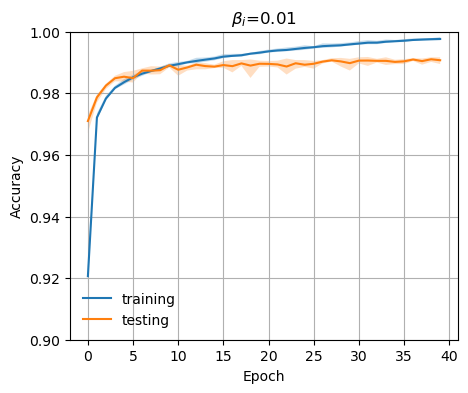

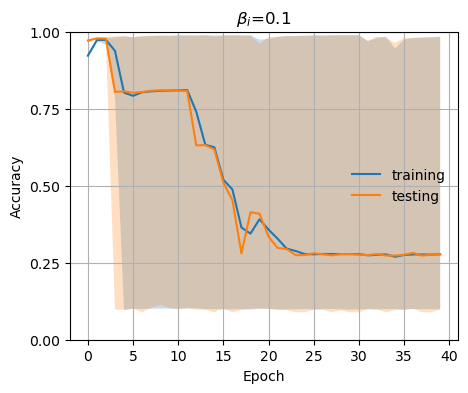

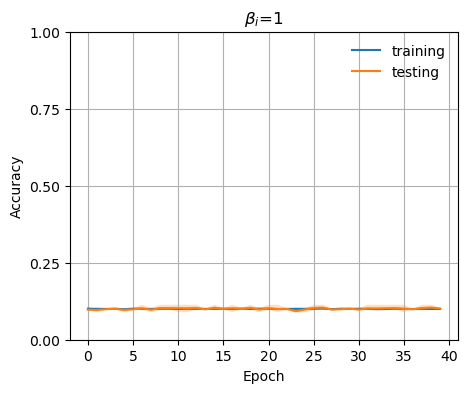

In [9]:

current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res",  **save_dict)
     
for ifbsc in range(len(fbsc_range)):
    testacctt = np.max(res[ifbsc,:,2,:], axis= -1)

    trainacctt = np.max(res[ifbsc,:,1,:], axis= -1)

    print(f'\t_'
        f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
        f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

for ifbsc in range(len(fbsc_range)):
    plt.figure(figsize=(5, 4))
    tt = res[ifbsc,:,1,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    tt = res[ifbsc,:,2,:]
    plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
    plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
    if np.min(tt)<0.8:
        plt.ylim([0.0, 1.0])
        plt.yticks(np.arange(0.0,1.01,0.25))
    else:
        plt.ylim([0.9, 1.0])
        plt.yticks(np.arange(0.9,1.01,0.02))
    plt.grid()
    plt.title(r'$\beta_i$'+f"={fbsc_range[ifbsc]}")
    plt.xlabel(f'Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False)

    current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f'Current Time: {current_time}')
    plt.savefig(res_path /f"aEP_cnn_MNIST_maxacc{np.max(tt)}-fbsc{fbsc_range[ifbsc]}-{current_time}.svg", format="svg")
